<a href="https://colab.research.google.com/github/aryan300/Great-Energy-Predictor/blob/main/Great_Energy_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Energy Forecasting in Buildings: Comparative Analysis of Machine Learning Algorithms

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*cfY3PQJ2iRBMOtEs6ms8MQ.png)

Evaluating the impact of energy efficiency upgrades poses challenges due to the inability to precisely determine a building's energy usage without the enhancements. Therefore, counterfactual models are developed to estimate the potential energy consumption before improvements. After the renovation, the actual energy consumption is compared to the modeled pre-upgrade values to quantify the efficiency gains. Enhanced modeling accuracy could enhance market incentives and facilitate access to lower-cost financing options for such retrofits.

Here we build these counterfactual models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

The evaluation metric is RMSE

Here, We will proceed with a systematic approach to construct the machine learning model:
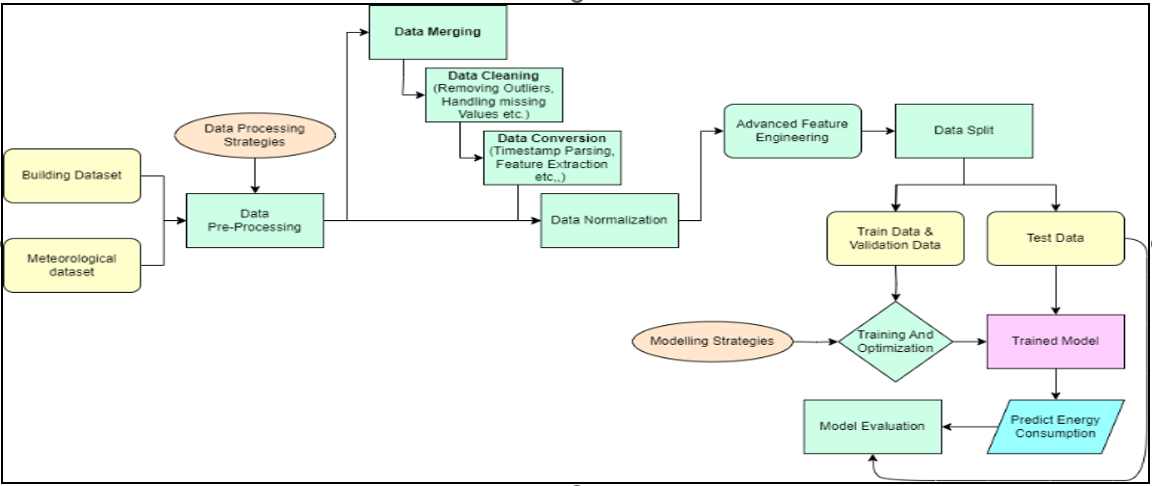

Acquire the dataset
Investigate the dataset
Preprocess the dataset for training
Develop a baseline model
Train and assess various models

Some of the problems related to dataset which we need to solve:
* Data cleanliness issues necessitate cleaning.
* Inconsistent data sources, such as meter and weather timestamps, must be addressed.
* Predictions are required for various loosely related sets of values, notably meter types.
* Crucial categorical features, like building IDs, require careful handling.
* Supplementing provided data with external sources complicates prioritization and initial focus areas.


In [ ]:
! pip install opendatasets pandas numpy matplotlib seaborn folium --q

In [ ]:
#To import all the important libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import KFold
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
!pwd

/content


In [ ]:
#od.download('https://www.kaggle.com/competitions/ashrae-energy-prediction/data')

In [ ]:
data_dir = '/content/drive/MyDrive/ashrae-energy-prediction'

In [ ]:
# To get list of files with their size
!ls -lh {data_dir}

total 2.5G
-rw------- 1 root root  45K Mar  9 22:04 building_metadata.csv
-rw------- 1 root root 427M Mar  9 22:04 sample_submission.csv
-rw------- 1 root root 1.4G Mar  9 22:04 test.csv
-rw------- 1 root root 648M Mar  9 22:04 train.csv
-rw------- 1 root root  15M Mar  9 22:04 weather_test.csv
-rw------- 1 root root 7.2M Mar  9 22:04 weather_train.csv


In [ ]:
# Training set
!head {data_dir}/train.csv

building_id,meter,timestamp,meter_reading
0,0,2016-01-01 00:00:00,0.0
1,0,2016-01-01 00:00:00,0.0
2,0,2016-01-01 00:00:00,0.0
3,0,2016-01-01 00:00:00,0.0
4,0,2016-01-01 00:00:00,0.0
5,0,2016-01-01 00:00:00,0.0
6,0,2016-01-01 00:00:00,0.0
7,0,2016-01-01 00:00:00,0.0
8,0,2016-01-01 00:00:00,0.0


In [ ]:
# building set
!head {data_dir}/building_metadata.csv

site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,Education,7432,2008,
0,1,Education,2720,2004,
0,2,Education,5376,1991,
0,3,Education,23685,2002,
0,4,Education,116607,1975,
0,5,Education,8000,2000,
0,6,Lodging/residential,27926,1981,
0,7,Education,121074,1989,
0,8,Education,60809,2003,


In [ ]:
# Weather Training set
!head {data_dir}/weather_train.csv

site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,25.0,6.0,20.0,,1019.7,0.0,0.0
0,2016-01-01 01:00:00,24.4,,21.1,-1.0,1020.2,70.0,1.5
0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
0,2016-01-01 05:00:00,19.4,,19.4,0.0,,0.0,0.0
0,2016-01-01 06:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
0,2016-01-01 07:00:00,21.1,,21.1,0.0,1018.8,210.0,1.5
0,2016-01-01 08:00:00,20.6,,20.0,0.0,1018.1,0.0,0.0


In [ ]:
# Test set
!head {data_dir}/test.csv

row_id,building_id,meter,timestamp
0,0,0,2017-01-01 00:00:00
1,1,0,2017-01-01 00:00:00
2,2,0,2017-01-01 00:00:00
3,3,0,2017-01-01 00:00:00
4,4,0,2017-01-01 00:00:00
5,5,0,2017-01-01 00:00:00
6,6,0,2017-01-01 00:00:00
7,7,0,2017-01-01 00:00:00
8,7,1,2017-01-01 00:00:00


In [ ]:
# Weather Test set
!head {data_dir}/weather_test.csv

site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2017-01-01 00:00:00,17.8,4.0,11.7,,1021.4,100.0,3.6
0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
0,2017-01-01 05:00:00,15.6,2.0,12.8,0.0,1022.1,130.0,2.1
0,2017-01-01 06:00:00,15.0,0.0,12.8,0.0,1021.7,150.0,1.5
0,2017-01-01 07:00:00,15.0,2.0,13.3,0.0,1021.6,0.0,0.0
0,2017-01-01 08:00:00,13.3,0.0,12.2,0.0,1021.4,0.0,0.0


In [ ]:

!head {data_dir}/sample_submission.csv

row_id,meter_reading
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0


In [ ]:
# To check no. of lines in training set
!wc -l {data_dir}/train.csv

20216101 /content/drive/MyDrive/ashrae-energy-prediction/train.csv


In [ ]:
# To check no. of lines in weather training set
!wc -l {data_dir}/weather_train.csv

139774 /content/drive/MyDrive/ashrae-energy-prediction/weather_train.csv


In [ ]:
# To check no. of lines in building set
!wc -l {data_dir}/building_metadata.csv

1450 /content/drive/MyDrive/ashrae-energy-prediction/building_metadata.csv


In [ ]:
# To check no. of lines in test set
!wc -l {data_dir}/test.csv

41697601 /content/drive/MyDrive/ashrae-energy-prediction/test.csv


In [ ]:
# No. of lines in weather test set
!wc -l {data_dir}/weather_test.csv

277244 /content/drive/MyDrive/ashrae-energy-prediction/weather_test.csv


In [ ]:
# No. of lines in submission set
!wc -l {data_dir}/sample_submission.csv

41697601 /content/drive/MyDrive/ashrae-energy-prediction/sample_submission.csv


Lets dicuss the observations:
* We are dealing with a supervised learning regression problem
* The ashrae-energy-prediction folder has 6 csv files.
> * building_metadata.csv
> * sample_submission.csv
> * test.csv
> * train.csv
> * weather_test.csv
> * weather_train.csv
* Total dataset data is 2.5 GB in size
* Training data has 20.2 million rows and 4 columns
* Test set is much larger (> 40 million rows)
* The training set has 4 columns:
> * building_id
> * meter
> * meter_reading
> * time_stamp

* The test set has all columns except the target column meter_reading and has extra column row_id .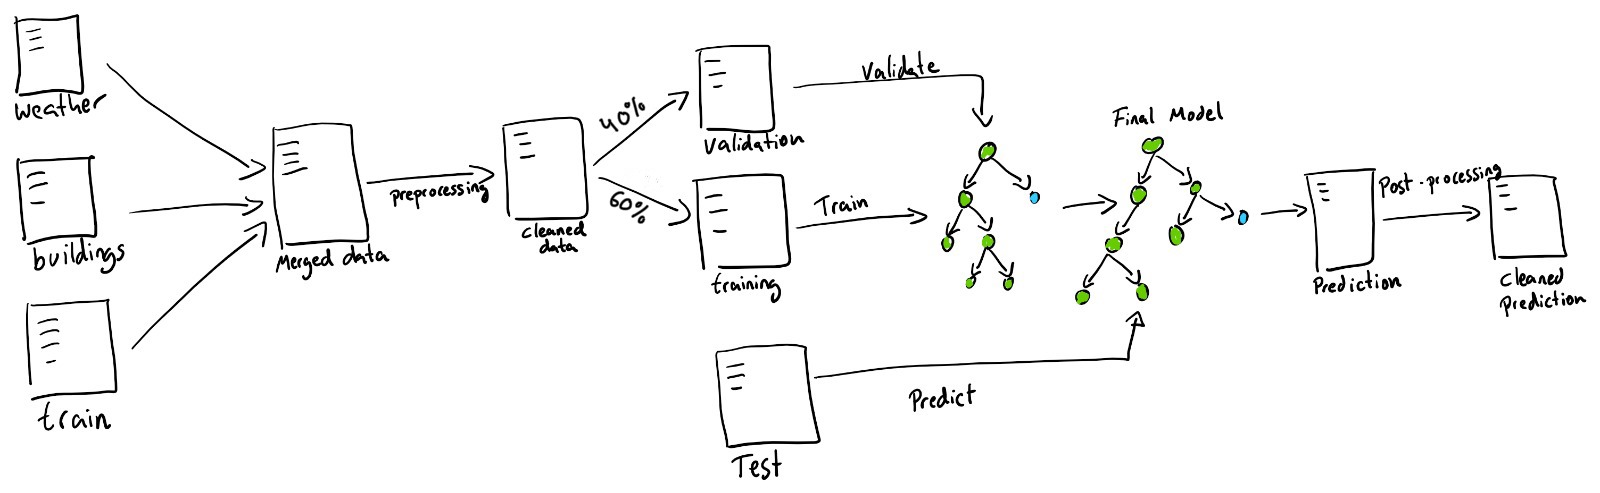

### Loading Training Set

Loading the entire dataset into Pandas was slow, so we used the following optimizations:

- Parse pickup datetime while loading data
- Specify data types for other columns
   - `int16` for building_id column
   - `int8` for meter column
   - `float32` for meter_reading column

In [ ]:
%%time
import random
#sample_frac=0.05
#selected_cols = 'building_id,meter,timestamp,meter_reading'.split(',')
dtypes = {
    'building_id':'int16',
    'meter':'int8',
    'meter_reading':'float32'

}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
train_df = pd.read_csv(data_dir+"/train.csv",
                 #usecols=selected_cols,
                 dtype=dtypes,
                 parse_dates=['timestamp'])
                 #skiprows=skip_row)

CPU times: user 13.3 s, sys: 1.42 s, total: 14.8 s
Wall time: 19.7 s


In [ ]:
train_df.sample(10)

building_id  meter           timestamp  meter_reading
10067778          910      0 2016-07-04 00:00:00       0.000000
484933            158      0 2016-01-09 19:00:00      13.870000
18602828          781      0 2016-12-03 04:00:00     107.782997
13283342          186      0 2016-08-30 16:00:00       3.690000
15976733          402      0 2016-10-17 08:00:00       3.360000
11994099         1251      1 2016-08-07 09:00:00    1396.069946
3607349           931      0 2016-03-09 00:00:00     248.000000
17931243         1049      0 2016-11-21 03:00:00      54.012501
1742531          1016      0 2016-02-01 14:00:00      29.940001
13702302           97      1 2016-09-07 02:00:00    4263.250000

In [ ]:
train_df[(train_df['building_id']==1226) & (train_df['timestamp']=='2016-02-11 09:00:00')]

building_id  meter           timestamp  meter_reading
2278837         1226      0 2016-02-11 09:00:00      38.628899
2278838         1226      1 2016-02-11 09:00:00       3.714300
2278839         1226      2 2016-02-11 09:00:00      44.375000

In [ ]:
building_dtypes={
    'site_id':'int8',
    'building_id':'int16',
    'square_feet':'int32',
    'year_built':'float16',
    'floor_count':'float16'}

In [ ]:
building_df=pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/building_metadata.csv',dtype=building_dtypes)

In [ ]:
building_df.sample(5)

site_id  building_id          primary_use  square_feet  year_built  \
1070       13         1070  Lodging/residential       230747         NaN   
612         4          612            Education        77055      1917.0   
237         2          237      Public services       101262      1982.0   
1011       10         1011            Education        65144         NaN   
632         4          632            Education        41297      1959.0   

      floor_count  
1070          NaN  
612           4.0  
237           NaN  
1011          4.0  
632           6.0

In [ ]:
weather_dtypes={
    'site_id':'int8',
    'air_temperature':'float16',
    'cloud_coverage':'float16',
    'dew_temperature':'float16',
    'precip_depth_1_hr':'float16',
    'sea_level_pressure':'float16',
    'wind_direction':'float16',
    'wind_speed':'float16',
}

In [ ]:
weather_train_df=pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/weather_train.csv',dtype=weather_dtypes,parse_dates=['timestamp'])

In [ ]:
weather_train_df.sample(5)

site_id           timestamp  air_temperature  cloud_coverage  \
34662         3 2016-12-13 08:00:00         4.398438             NaN   
118791       13 2016-07-28 16:00:00        18.906250             NaN   
132063       15 2016-02-04 11:00:00         3.300781             0.0   
101661       11 2016-08-13 05:00:00        18.593750             NaN   
103885       11 2016-11-14 06:00:00         6.800781             NaN   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
34662         -1.700195                0.0              1021.5   
118791        16.093750                0.0              1017.0   
132063        -2.199219                NaN              1015.5   
101661        14.703125                NaN              1012.0   
103885         2.000000                NaN              1010.0   

        wind_direction  wind_speed  
34662            350.0    2.599609  
118791           360.0    4.601562  
132063           290.0    4.101562  
101661            60.0    1.000000  
103885           220.0    5.101562

###Vlaue of max min cloud coverage

In [ ]:
max_cloud_coverage = weather_train_df['cloud_coverage'].max()
min_cloud_coverage = weather_train_df['cloud_coverage'].min()
print("Maximum cloud coverage value :", max_cloud_coverage, min_cloud_coverage)

Maximum cloud coverage value: 9.0 0.0


In [ ]:
weather_test_df=pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/weather_test.csv',dtype=weather_dtypes,parse_dates=['timestamp'])

In [ ]:
weather_test_df.sample(5)

site_id           timestamp  air_temperature  cloud_coverage  \
155994        8 2018-12-23 12:00:00         6.699219             0.0   
138919        8 2017-01-11 01:00:00        16.093750             NaN   
95931         5 2017-12-24 18:00:00         9.000000             NaN   
49301         2 2018-08-27 22:00:00        40.000000             2.0   
250777       14 2017-12-10 20:00:00         2.800781             NaN   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
155994         5.000000                0.0              1024.0   
138919        12.796875                0.0              1029.0   
95931          9.000000                NaN                 NaN   
49301          3.300781                0.0              1006.5   
250777        -5.601562                0.0              1014.5   

        wind_direction  wind_speed  
155994             0.0    0.000000  
138919           110.0    2.599609  
95931            240.0    5.101562  
49301            260.0    5.699219  
250777           260.0    3.599609

weather_[train/test].csv has the following columns:

Weather data from a meteorological station as close as possible to the site.

* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second




### Loading Test Data

In [ ]:
test_df=pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/test.csv',dtype=dtypes,parse_dates=['timestamp'])

In [ ]:
test_df.sample(5)

row_id  building_id  meter           timestamp
20510506  20510506          960      0 2017-04-26 11:00:00
6560640    6560640          207      1 2018-04-09 00:00:00
30801060  30801060         1148      0 2018-07-02 14:00:00
36992120  36992120         1225      1 2018-12-02 04:00:00
23606634  23606634          966      2 2018-06-22 12:00:00

file uploads. test.csv has no feature data; it exists so we can get our predictions into the correct order.

* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period

## 2. Explore the Dataset
The steps need to complete in this section are as follows:
- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

### Training data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [ ]:
train_df.describe()

building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117122e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07

In [ ]:
train_df.timestamp.min(),train_df.timestamp.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 23:00:00'))

Let us define the basic graph features before we proceed for visualization.

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (8, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

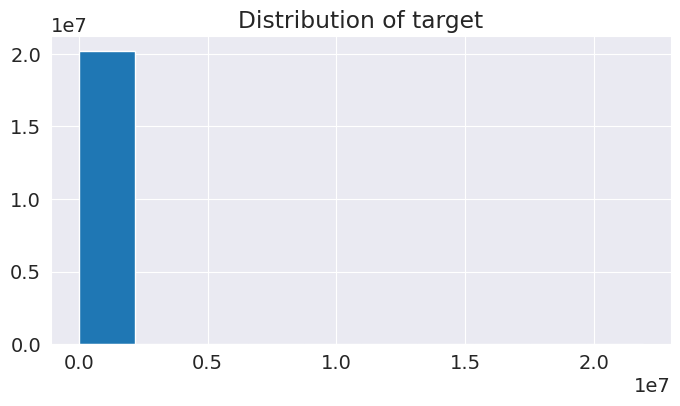

In [ ]:
plt.hist(train_df['meter_reading']);
plt.title('Distribution of target');

The target value is highly right skewed or positively skewed data. So applying log transformation will make the distribution normal.
* To take care of zero values, log(1+x) is considered instead of log(x).

Observations:
* 20+ million rows
* 4 types of meters
* 1449 buildings.
* `meter_reading` values are widely spread from 0 to 2.19047*10^7 kWh
* Dates range from 1st Jan 2016 to 31st December 2016
* The dataset takes up ~2.9 MB of space in the RAM
* No missing values
* The reason for zero meter_reading is uncertain and need to deal properly.

### Test Set

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   row_id       int64         
 1   building_id  int16         
 2   meter        int8          
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(1), int8(1)
memory usage: 755.6 MB


In [ ]:
test_df.describe()

row_id   building_id         meter
count  4.169760e+07  4.169760e+07  4.169760e+07
mean   2.084880e+07  8.075824e+02  6.642857e-01
std    1.203706e+07  4.297680e+02  9.278067e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.042440e+07  4.047500e+02  0.000000e+00
50%    2.084880e+07  9.000000e+02  0.000000e+00
75%    3.127320e+07  1.194250e+03  1.000000e+00
max    4.169760e+07  1.448000e+03  3.000000e+00

In [ ]:
test_df.timestamp.min(),test_df.timestamp.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

Observations:
* 40+ million rows of data
* No missing values
* Same buildings as of train data from 0 to 1448
* same meter types as of training
* dates range from Jan 1st 2017 to Dec 31st 2018 (different from training set)

### Weather data
There are 2 weather csv files, one is weather train data and the other is weather test data. Let us consider them separately and analyse.

#### Weather train data
Let us explore the weather train data.

In [ ]:
weather_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


In [ ]:
weather_train_df.describe()


site_id  air_temperature  cloud_coverage  dew_temperature  \
count  139773.000000    139718.000000         70600.0    139660.000000   
mean        7.478977              NaN             NaN              NaN   
std         4.604744         0.000000             0.0         0.000000   
min         0.000000       -28.906250             0.0       -35.000000   
25%         3.000000         7.199219             0.0         0.600098   
50%         7.000000        15.000000             2.0         8.296875   
75%        11.000000        22.203125             4.0        14.398438   
max        15.000000        47.187500             9.0        26.093750   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count            89484.0            129155.0        133505.0  139469.000000  
mean                 NaN                 NaN             NaN            NaN  
std                  NaN                 NaN             NaN       0.000000  
min                 -1.0               968.0             0.0       0.000000  
25%                  0.0              1012.0            80.0       2.099609  
50%                  0.0              1016.5           190.0       3.099609  
75%                  0.0              1021.0           280.0       5.000000  
max                343.0              1046.0           360.0      19.000000

In [ ]:
weather_train_df.timestamp.min(),weather_train_df.timestamp.max()


(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 23:00:00'))

Observations:
* 139773 rows of data
* Total 16 sites ranging from 0 to 15
* All weather data columns except `site_id` and `timestamp` has missing values.
* The dataset takes up 3.1 MB RAM.
* No abnormal values could be found in the statstical summary of weather data.
* Weather train has one year data.

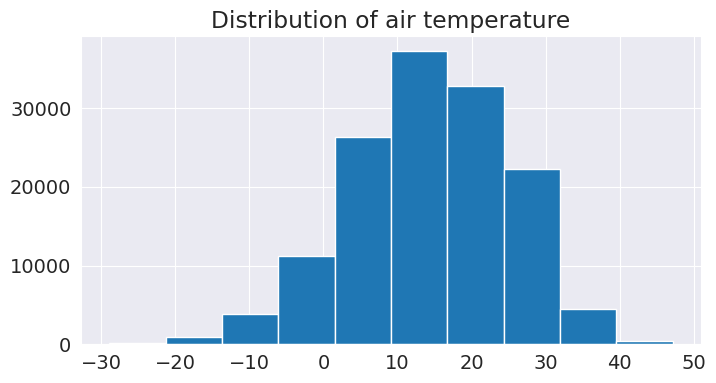

In [ ]:
plt.hist(weather_train_df.air_temperature);
plt.title('Distribution of air temperature');

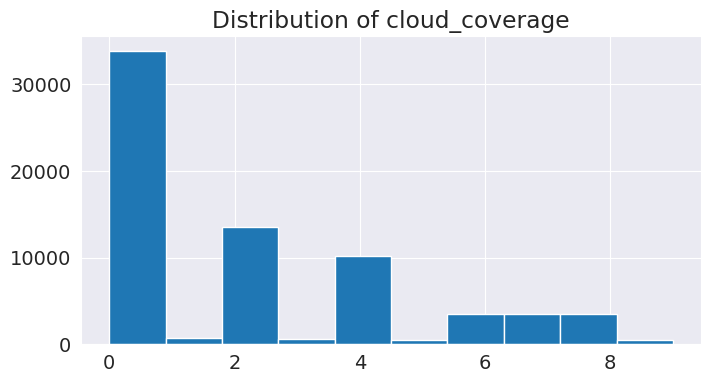

In [ ]:
plt.hist(weather_train_df.cloud_coverage);
plt.title('Distribution of cloud_coverage');

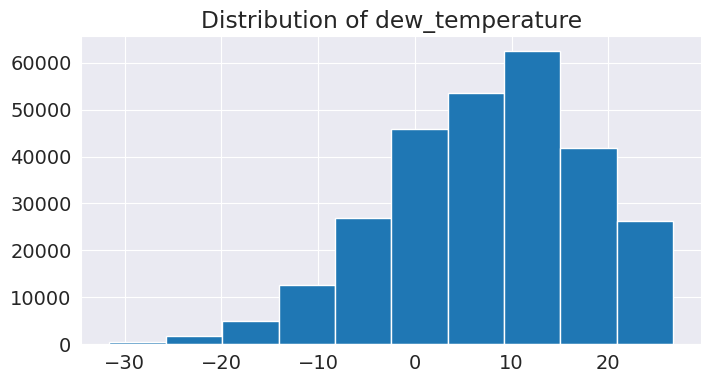

In [ ]:
plt.hist(weather_test_df.dew_temperature);
plt.title('Distribution of dew_temperature');

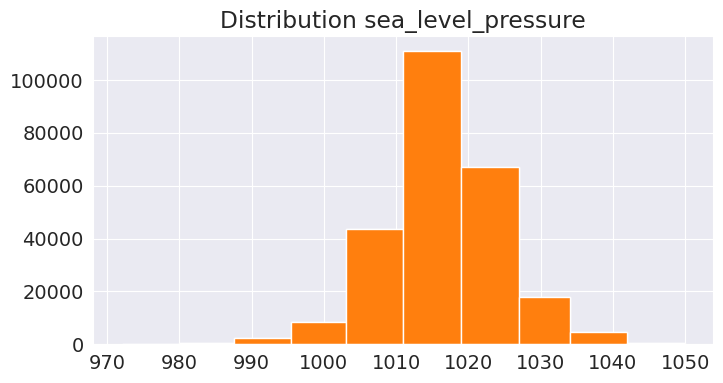

In [ ]:
plt.hist(weather_test_df.sea_level_pressure);
plt.title('Distribution sea_level_pressure');plt.hist(weather_test_df.sea_level_pressure);
plt.title('Distribution sea_level_pressure');

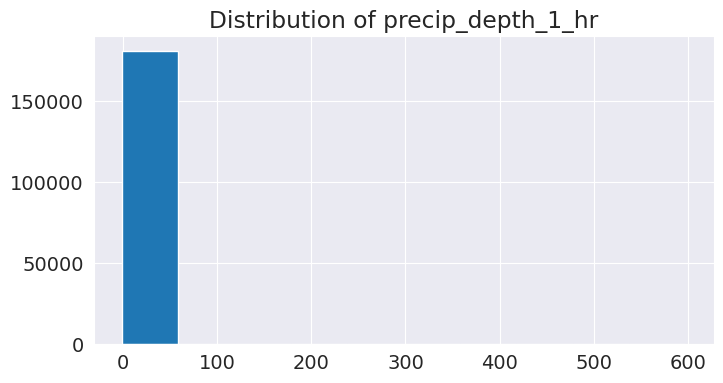

In [ ]:
plt.hist(weather_test_df.precip_depth_1_hr);
plt.title('Distribution of precip_depth_1_hr');

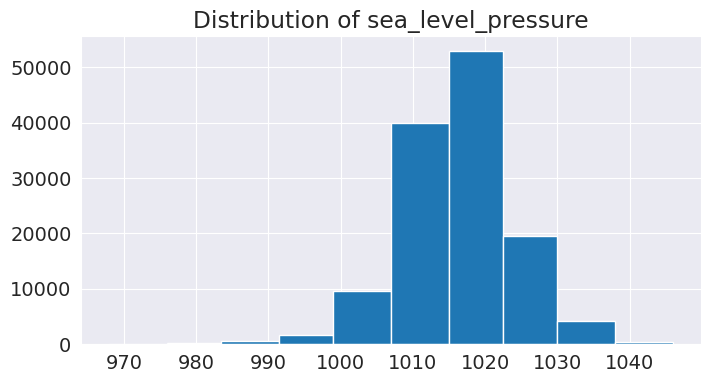

In [ ]:
plt.hist(weather_train_df.sea_level_pressure);
plt.title('Distribution of sea_level_pressure');

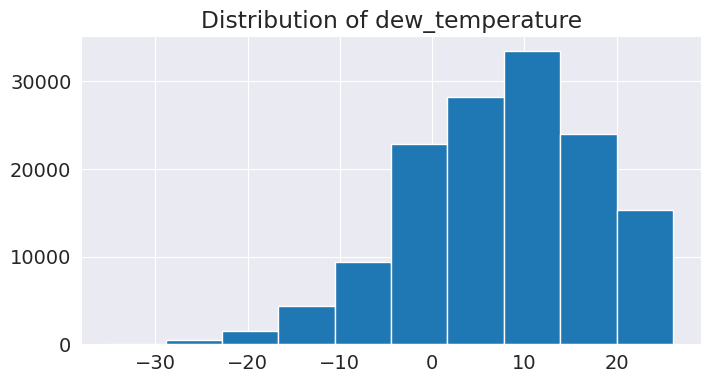

In [ ]:
plt.hist(weather_train_df.dew_temperature);
plt.title('Distribution of dew_temperature');

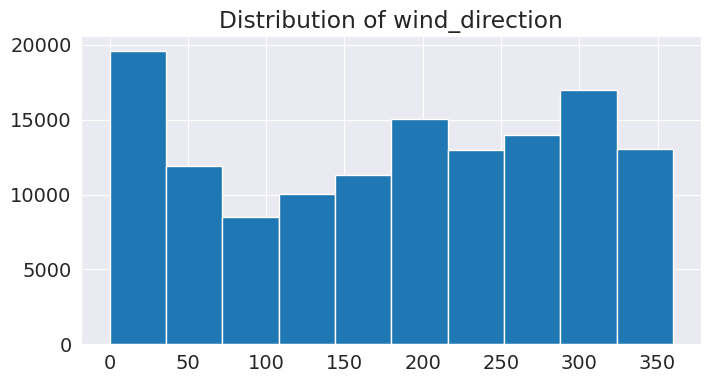

In [ ]:
plt.hist(weather_train_df.wind_direction);
plt.title('Distribution of wind_direction');

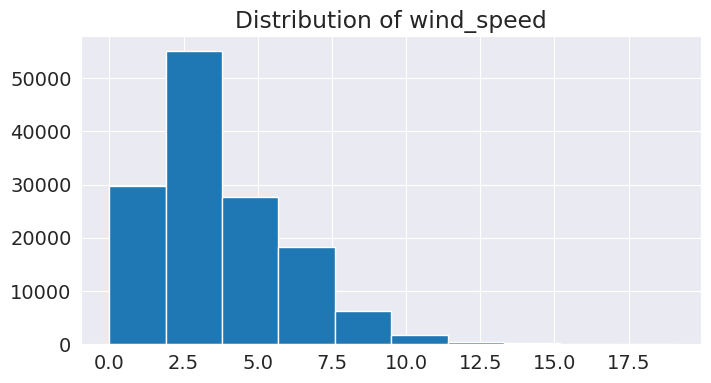

In [ ]:
plt.hist(weather_train_df.wind_speed);
plt.title('Distribution of wind_speed');

* All the weather train data columns except cloud_coverage, precipitaion_depth_1hr and wind_direction are distributed approximately noramal. This distribution picture is useful while filling the missing values.
* If the distribution is normal then it is appropriate to fill with mean or median value else depends on the distribution shape weather forwad fill or backward fill.

#### Weather test data
Let us explore the weather test data.

In [ ]:
weather_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             277243 non-null  int8          
 1   timestamp           277243 non-null  datetime64[ns]
 2   air_temperature     277139 non-null  float16       
 3   cloud_coverage      136795 non-null  float16       
 4   dew_temperature     276916 non-null  float16       
 5   precip_depth_1_hr   181655 non-null  float16       
 6   sea_level_pressure  255978 non-null  float16       
 7   wind_direction      264873 non-null  float16       
 8   wind_speed          276783 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 6.1 MB


In [ ]:
weather_test_df.describe()

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  277243.000000    277139.000000        136795.0    276916.000000   
mean        7.484654              NaN             NaN              NaN   
std         4.616959         0.000000             0.0         0.000000   
min         0.000000       -28.093750             0.0       -31.593750   
25%         3.000000         7.199219             0.0         0.600098   
50%         7.000000        15.000000             2.0         8.398438   
75%        12.000000        22.203125             4.0        15.000000   
max        15.000000        48.312500             9.0        26.703125   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count           181655.0            255978.0        264873.0  276783.000000  
mean                 NaN                 NaN             NaN            NaN  
std                  NaN                 NaN             NaN       0.000000  
min                 -1.0               972.0             0.0       0.000000  
25%                  0.0              1011.5            80.0       2.099609  
50%                  0.0              1016.5           190.0       3.099609  
75%                  0.0              1021.0           280.0       4.601562  
max                597.0              1050.0           360.0      24.203125

In [ ]:
weather_test_df.timestamp.min(),weather_test_df.timestamp.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

Observations:
* 277242 rows of data
* Total 16 sites ranging from 0 to 15
* All weather data columns except `site_id` and `timestamp` has missing values.
* The dataset takes up 6.1 MB RAM.
* No abnormal values could be found in the statstical summary of weather test data.
* Weather test has two years data.

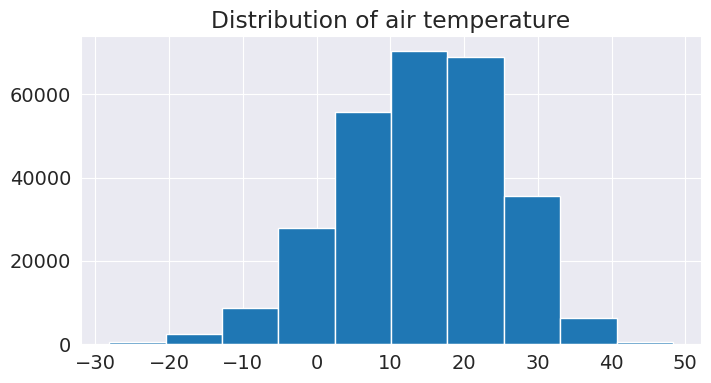

In [ ]:
plt.hist(weather_test_df.air_temperature);
plt.title('Distribution of air temperature');

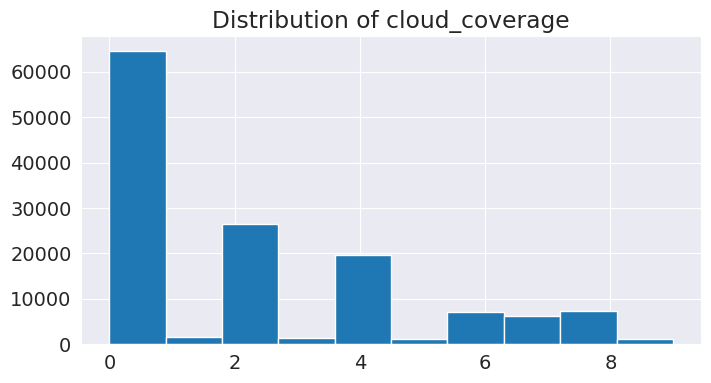

In [ ]:
plt.hist(weather_test_df.cloud_coverage);
plt.title('Distribution of cloud_coverage');

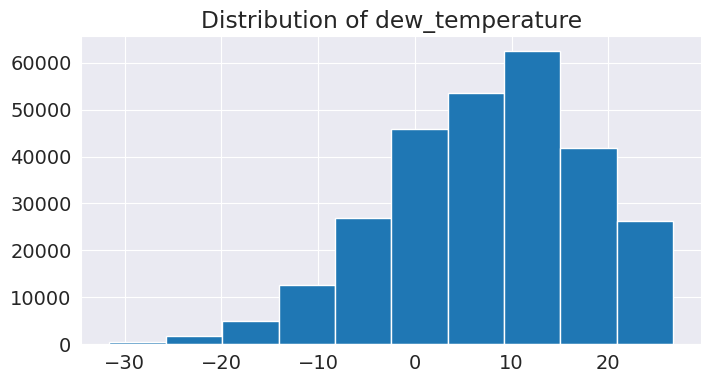

In [ ]:
plt.hist(weather_test_df.dew_temperature);
plt.title('Distribution of dew_temperature');

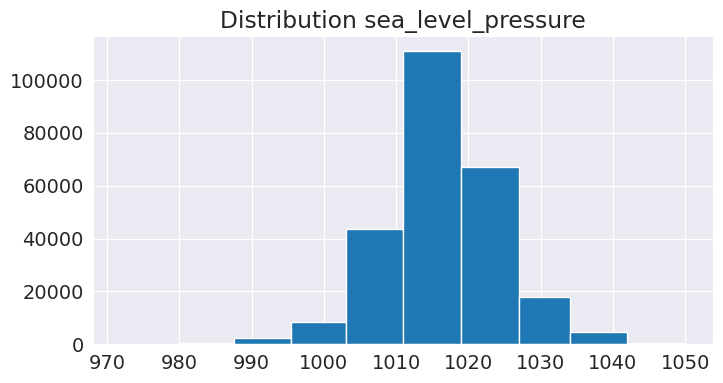

In [ ]:
plt.hist(weather_test_df.sea_level_pressure);
plt.title('Distribution sea_level_pressure');

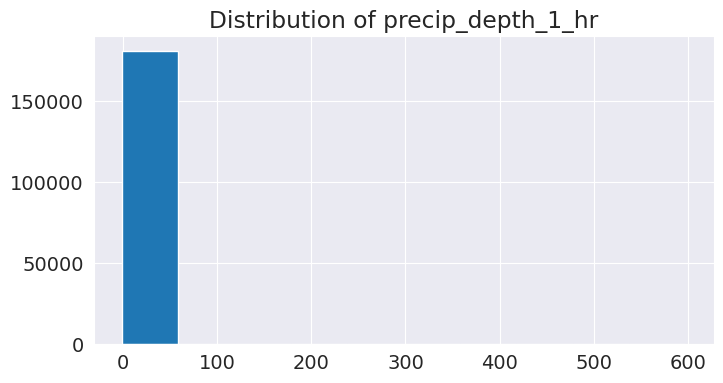

In [ ]:
plt.hist(weather_test_df.precip_depth_1_hr);
plt.title('Distribution of precip_depth_1_hr');

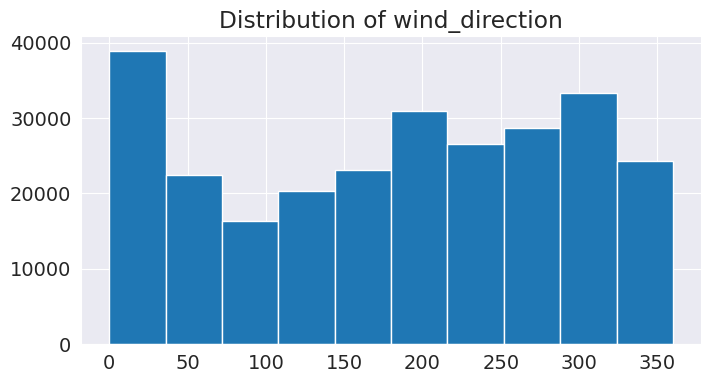

In [ ]:
plt.hist(weather_test_df.wind_direction);
plt.title('Distribution of wind_direction');

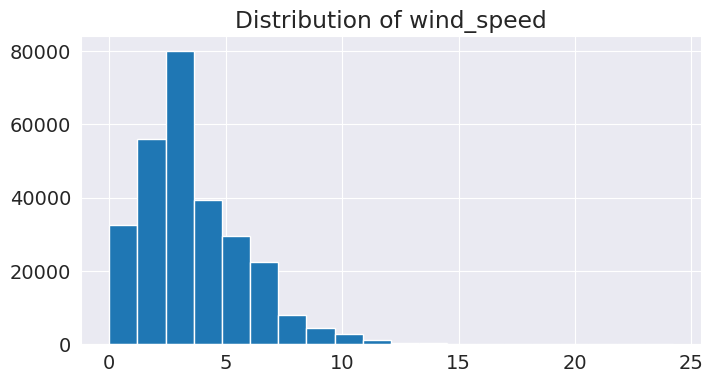

In [ ]:
plt.hist(weather_test_df.wind_speed,20);
plt.title('Distribution of wind_speed');

### Building Data

In [ ]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int8   
 1   building_id  1449 non-null   int16  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int32  
 4   year_built   675 non-null    float16
 5   floor_count  355 non-null    float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB


In [ ]:
building_df.describe()

site_id  building_id    square_feet  year_built  floor_count
count  1449.000000  1449.000000    1449.000000    675.0000   355.000000
mean      6.952381   724.000000   92111.776398         inf     3.740234
std       5.003432   418.434583  110769.950997     31.0625     3.333984
min       0.000000     0.000000     283.000000   1900.0000     1.000000
25%       3.000000   362.000000   23012.000000   1949.0000     1.000000
50%       5.000000   724.000000   57673.000000   1970.0000     3.000000
75%      13.000000  1086.000000  115676.000000   1995.0000     5.000000
max      15.000000  1448.000000  875000.000000   2017.0000    26.000000

Observations:
* The data is collected from 16 different sites worldwide
* Total 1449 buildings readings are present
* The square feet of the buildings ranges from 283 to 875000. The distribution is quite high.
* The buildings built year is ranges from 1900 to 2017. Both 19th centuary and 20th centuary buildings are present. This is quite challenging.
* The floor_count of the buildings ranges from 1 to 26.

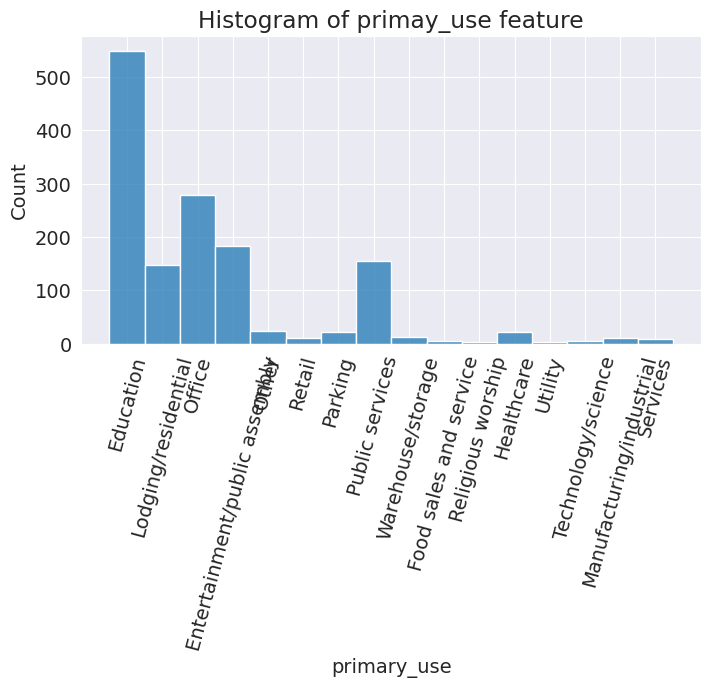

In [ ]:
plt.xticks(rotation=75)
sns.histplot(building_df.primary_use);
plt.title('Histogram of primay_use feature');

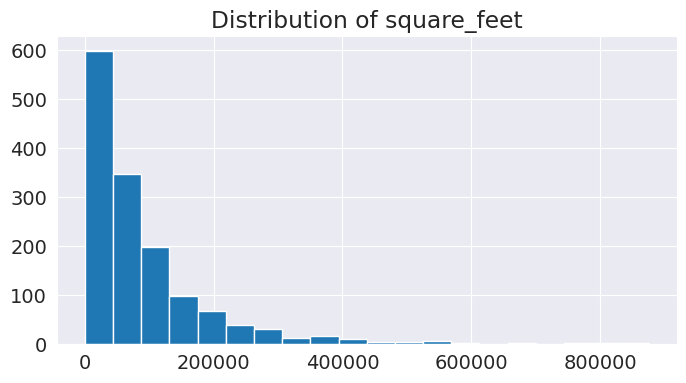

In [ ]:
plt.hist(building_df.square_feet,bins=20);
plt.title('Distribution of square_feet');

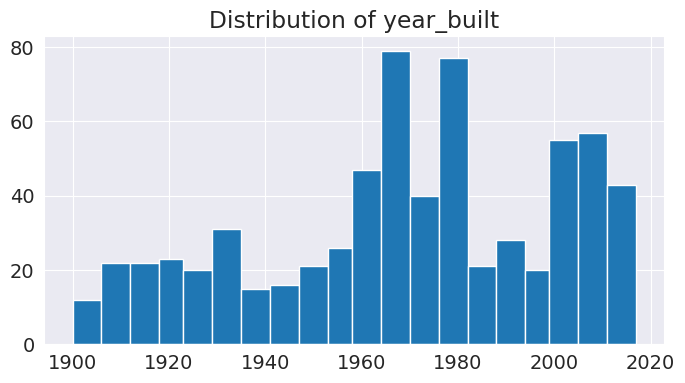

In [ ]:
plt.hist(building_df.year_built,bins=20);
plt.title('Distribution of year_built');

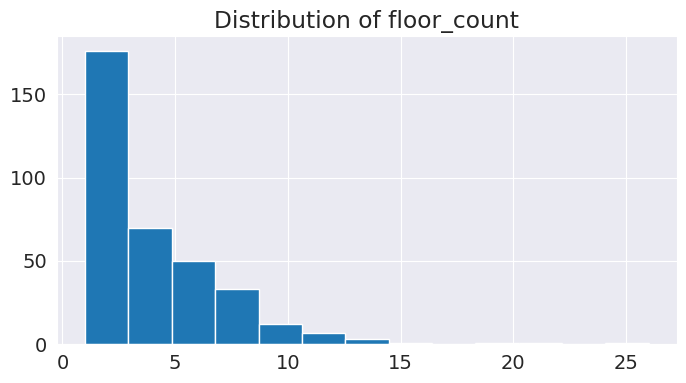

In [ ]:
plt.hist(building_df.floor_count,bins=13);
plt.title('Distribution of floor_count');

## Data Preprocessing
Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset.

### Fill/Remove missing values
If the percentage of missing values is less than 50 then fill it using the forward fill technique else remove the missing value rows.

Let us check the missing values in train data.

In [ ]:
train_df.isna().sum()/len(train_df)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

Test also does not contain any missing values.

Now let us test weather data.

In [ ]:
weather_train_df.isna().sum()/len(weather_train_df)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

Weather train data has missing values and the percentages are less tahn 50%. Let us define a helper function to fill these values.

In [ ]:
def fill_missing(df):
  for i in df.columns:
    if df[i].isna().sum()!=0:
      if df[i].dtype == 'float16':
        df[i]=df[i].astype('float32')
      if df[i][0]==np.nan:
        df[i][0]=df[i].mean()
      df[i].fillna(method='ffill',inplace=True)
  return df

In [ ]:
weather_train_df=fill_missing(weather_train_df)

In [ ]:
weather_test_df=fill_missing(weather_test_df)

Let us check the missing values in building data

In [ ]:
building_df.isna().sum()/len(building_df)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

In building dataframe, the columns `year_built` and `floor_count` has missing values and their percentages are grater than 50%. So let us drop these columns.

In [ ]:
building_df.drop(columns=['year_built','floor_count'],inplace=True)

#### Weather data time alignment


According to this [thread](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/114483#latest-659257), with high probability there are discrepancies between measurement timestamps and weather timestamps.
Particularly, it looks like weather data is not in local time format.

In [ ]:
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

<ipython-input-20-1bbb1263ca8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


Text(0.5, 1.0, 'Mean temperature rank by hour (init timestamps)')

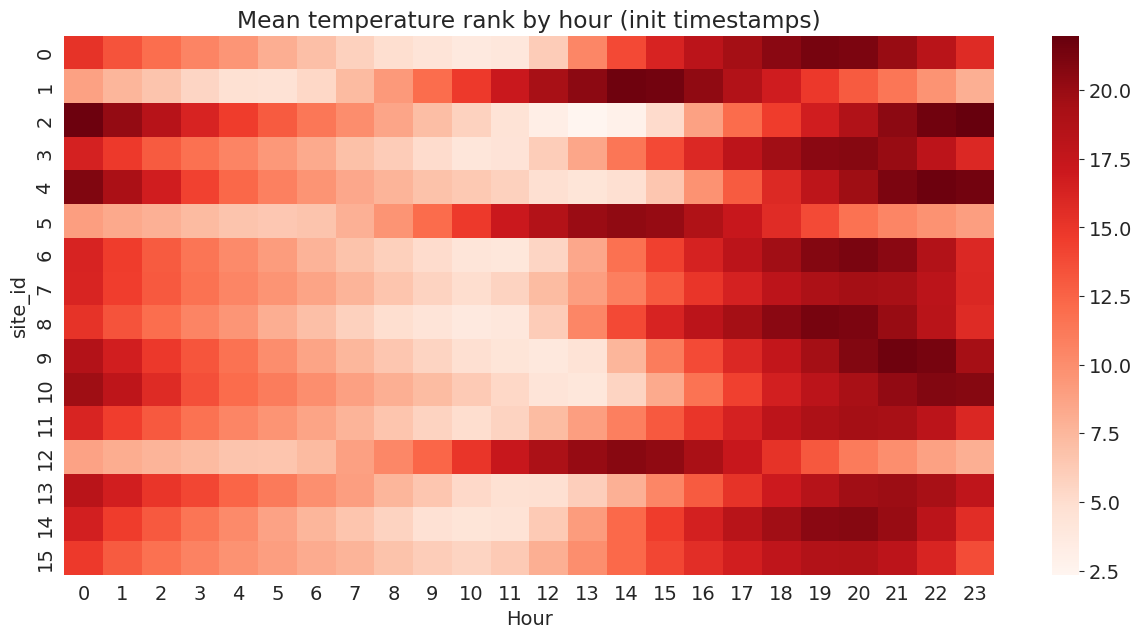

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_2d,cmap='Reds');
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour (init timestamps)')

The above heatmap shows that different site_id's have maximum temperatures at different hours.

This is certainly not possible. So we can conclude that weather data is not in local time format.

In [ ]:
def time_alignment(df):
  temp_df=df[['site_id','timestamp','air_temperature']]
  # calculate ranks of hourly temperatures within date/site_id chunks
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
  # create 2D dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
  df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
  # align scale, so each value within row is in [0,1] range
  df_2d = df_2d / df_2d.max(axis=1).values.reshape((-1,1))
  # sort by 'closeness' of hour with the highest temperature
  site_ids_argmax_maxtemp=pd.Series(np.argmax(df_2d.values,axis=1)).sort_values().index
  # assuming (1,5,12) tuple has the most correct temp peaks at 14:00
  site_ids_offsets= pd.Series(df_2d.values.argmax(axis=1) - 14)
  # align rows so that site_id's with similar temperature hour's peaks are near each other
  df_2d=df_2d.iloc[site_ids_argmax_maxtemp]
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
  # add offset
  temp_df['timestamp_aligned'] = (temp_df.timestamp - pd.to_timedelta(temp_df.offset, unit='H'))
  # replace the timestamp with aligned timestamps in the original dataframe
  df['timestamp']=temp_df['timestamp_aligned']
  return df

In [ ]:
weather_train_df=time_alignment(weather_train_df)
weather_test_df=time_alignment(weather_test_df)

<ipython-input-22-bee7c2cc3f87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
<ipython-input-22-bee7c2cc3f87>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
<ipython-input-22-bee7c2cc3f87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Now we will check the hourly mean tempaeratures rank after time alignment

In [ ]:
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

<ipython-input-24-1bbb1263ca8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


Text(0.5, 1.0, 'Mean temperature rank by hour (aligned timestamps)')

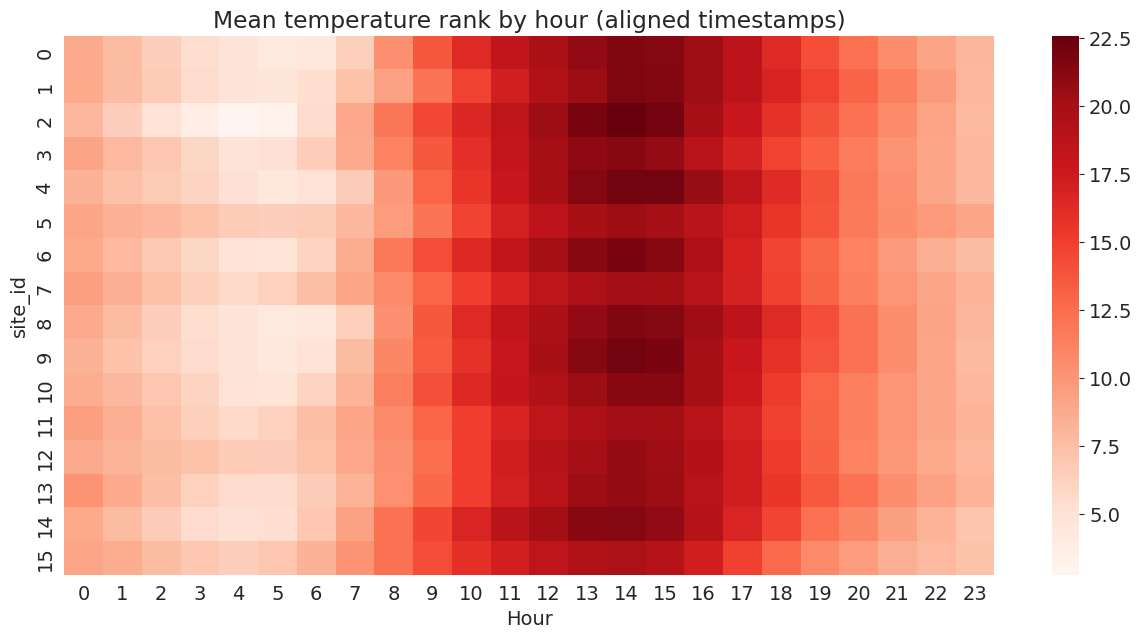

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_2d,cmap='Reds');
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour (aligned timestamps)')

From this graph we can conclude that the timestamps are aligned.

### Encode categorical columns
Machine Learning models will accept only numerical values and hence the object data types need to be converted into numerical.

We have only one categorical column out of all the datasets and that is in building dataset. The `primary_use` column in the building dataset is object type. There are different techniques to convert the string type columns into numerical. Since one hot encoding technique increases the no.of columns and tend to increase the size of the dataset, which inturn reduces the speed of computation. Hence in this notebook we are using 'LabelEncoder' to convert strings to numericals.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode categorical column primary use
le = LabelEncoder()
building_df["primary_use"] = le.fit_transform(building_df["primary_use"])

In [ ]:
building_df['primary_use']=building_df['primary_use'].astype('int8')

### Merging Data
We have completed the data preprocessing in individual datasets. Now it's time to merge the appropriate datasets and do data cleaning. The auxillary datasets need to merge with the train and test sets appropriately.

First, let us consider the training set and merge with the building set on common column `building_id`. Next the resultant dataset is merged with weather dataset on common features `site_id` and `time_stamp`.

In [ ]:
#merge training data with building and weather data
train_build_df=train_df.merge(building_df,on='building_id',how='left')
train_merge_df=train_build_df.merge(weather_train_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
#del weather_train_df, train_df,train_build_df

In [ ]:
train_merge_df.isna().sum()

building_id                0
meter                      0
timestamp                  0
meter_reading              0
site_id                    0
primary_use                0
square_feet                0
air_temperature       103451
cloud_coverage        103451
dew_temperature       103451
precip_depth_1_hr     103451
sea_level_pressure    103451
wind_direction        103451
wind_speed            103451
dtype: int64

In [ ]:
train_merge_df=fill_missing(train_merge_df)

In [ ]:
train_merge_df.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

Will merge the test data later.

In [ ]:
# site 0 meter reading is given in KBTU, hence convert them to kwh
train_merge_df.loc[train_merge_df[train_merge_df['site_id']==0].index,'meter_reading']=train_merge_df[train_merge_df['site_id']==0]['meter_reading']*0.2931

### Drop outliers and unused features

Let us plot the hourly and daily average meter_reading for each site.

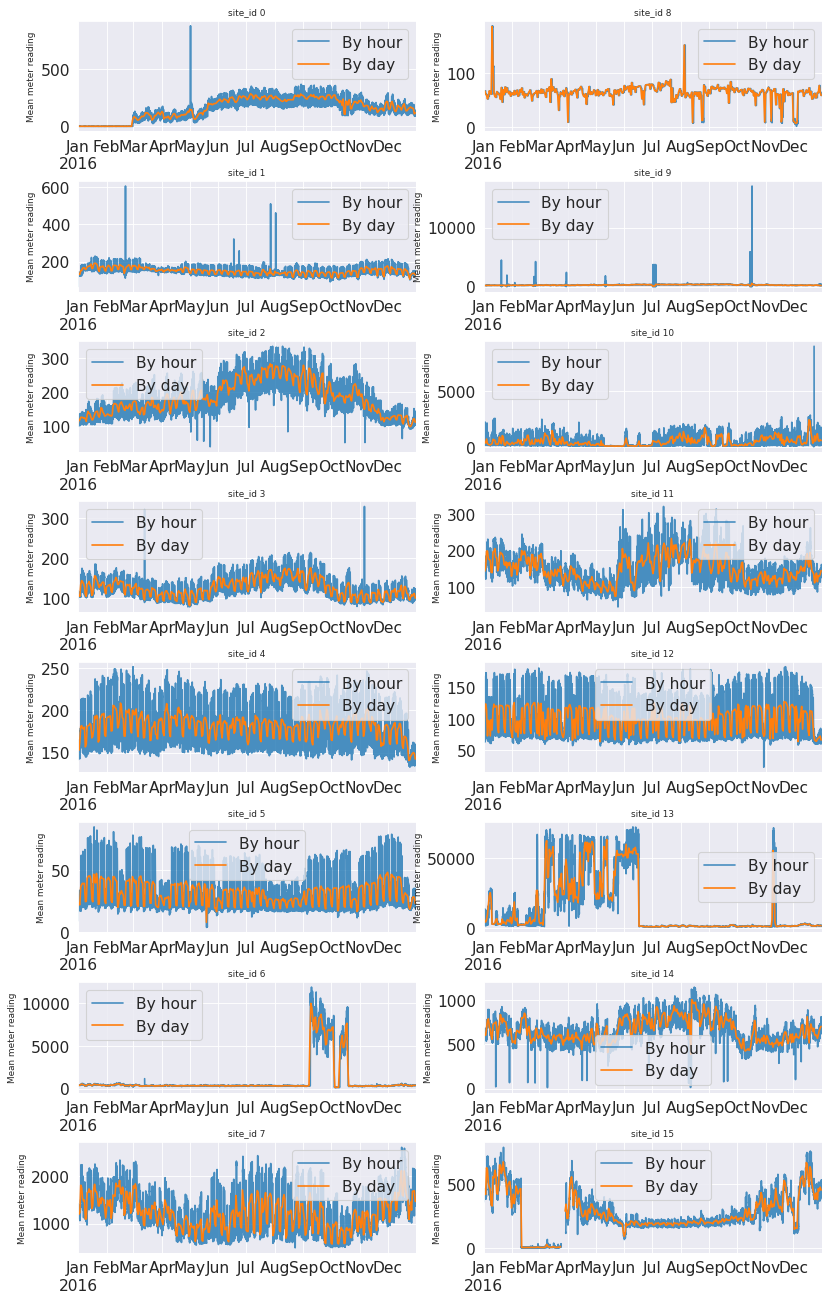

In [ ]:
fig, axes = plt.subplots(8,2,figsize=(12, 20), dpi=80)
plt.xticks(rotation=75)
for i in range(train_merge_df['site_id'].nunique()):
    train_merge_df[train_merge_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=8);
    train_merge_df[train_merge_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=8);
    plt.subplots_adjust(hspace=0.45)

As you can see above, the site 0 looks weired until May 20. It is reported in this discussion by @barnwellguy that all electricity meter is 0 until May 20 for site_id == 0. Let's remove these data from training data. And also sites 6, 10, 13 and 15 looks wierd at some particular durations. So let us remove all zero meter_reading rows from the training data whatever may be the reason for this.

In [ ]:
train_merge_df=train_merge_df[train_merge_df['meter_reading']!=0]
train_merge_df = train_merge_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

Let us plot the scatter plot using building_id and meter_reading to notice the outliers. This is going to do with 1% training data to get quick response.

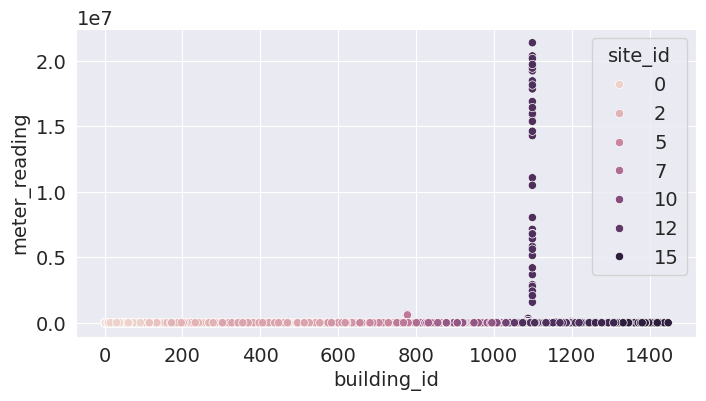

In [ ]:
train_sample=train_merge_df.sample(202161)
sns.scatterplot(x=train_sample.building_id,y=train_sample.meter_reading,hue=train_sample.site_id);
del train_sample

The above scatterplot shows that there is a building whose meter_readings are very much higher and appearing as outliers. So we should remove these outliers to get better results.

Let us identify this building by sorting the dataframe.

In [ ]:
train_merge_df.sort_values('meter_reading',ascending=False).head(5)

building_id  meter           timestamp  meter_reading  site_id  \
8907488          1099      2 2016-06-13 09:00:00     21904700.0       13   
8738539          1099      2 2016-06-10 09:00:00     21889900.0       13   
8736187          1099      2 2016-06-10 08:00:00     21874500.0       13   
17286421         1099      2 2016-11-09 14:00:00     21847900.0       13   
8905140          1099      2 2016-06-13 08:00:00     21844500.0       13   

          primary_use  square_feet  air_temperature  cloud_coverage  \
8907488             0       332884        24.406250             4.0   
8738539             0       332884        30.000000             4.0   
8736187             0       332884        28.296875             4.0   
17286421            0       332884        15.000000             2.0   
8905140             0       332884        22.796875             4.0   

          dew_temperature  precip_depth_1_hr  sea_level_pressure  \
8907488         17.203125                0.0              1013.0   
8738539         19.406250                0.0              1007.0   
8736187         18.906250                0.0              1007.5   
17286421         1.700195                0.0              1023.5   
8905140         16.703125                0.0              1013.5   

          wind_direction  wind_speed  
8907488            210.0    2.099609  
8738539            210.0    4.601562  
8736187            230.0    4.601562  
17286421           230.0    4.601562  
8905140            160.0    4.601562

The above result shows that building 1099 is having the highest meter_reading. So let us remove these building rows.

In [ ]:
train_merge_df = train_merge_df [ train_merge_df['building_id'] != 1099 ]

### Feature engineering
The dataset is time series because we have timestamp column in our data. Using this time feature directly will not help in any way beacuse model will not learn anything from this time column. So we have to extract useful features from this time column.

In [ ]:
def breakdown_timestamp(dataframe):
   dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
   dataframe['day']= np.uint8(dataframe['timestamp'].dt.day)
   dataframe['weekday']= np.uint8(dataframe['timestamp'].dt.weekday)
   dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)
   #dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
   dataframe.drop(['timestamp'],axis=1,inplace=True)
   return dataframe

In [ ]:
train_merge_df=breakdown_timestamp(train_merge_df)

At this stage, we will apply logarithmic function to meter_reading values to make the distribution normal.

In [ ]:
# take logarthmic value of meter reading
train_merge_df['meter_reading']=np.log1p(train_merge_df["meter_reading"])

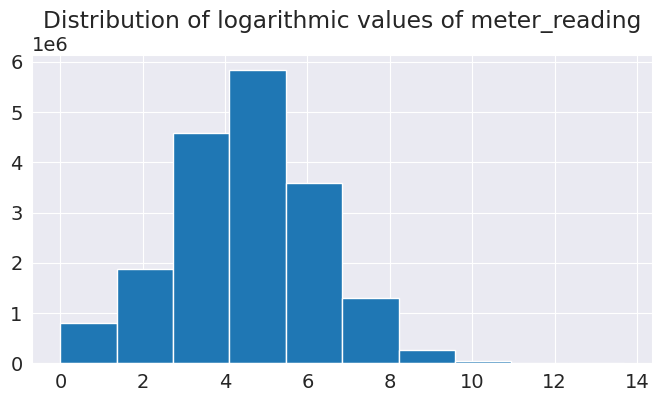

In [ ]:
plt.hist(train_merge_df['meter_reading']);
plt.title('Distribution of logarithmic values of meter_reading');

### Extract Inputs & Outputs
In this section, we will select input features and target column.

In [ ]:
input_columns=['building_id', 'site_id','primary_use', 'square_feet', 'air_temperature', 'cloud_coverage','dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed', 'hour', 'day','weekday', 'month']

In [ ]:
output_columns='meter_reading'

### Split Training & Validation Set
Taking 100% training data.
Splitting
* 60% as training set.
* 40% as validation set.

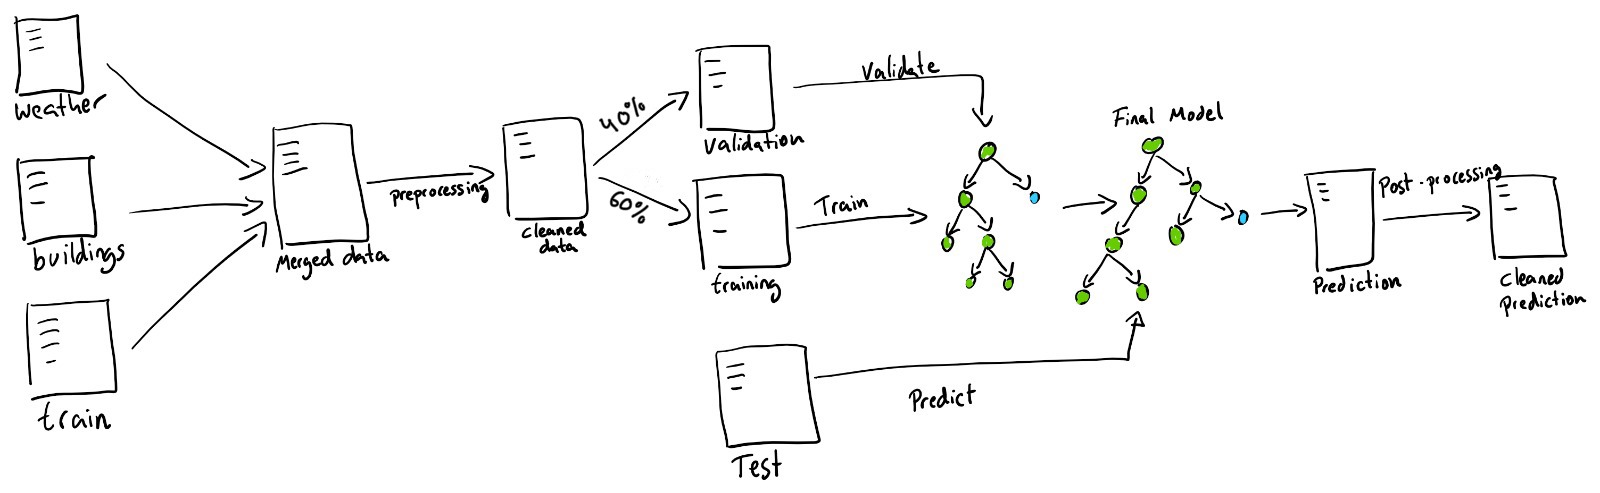

In [ ]:
from sklearn.model_selection import train_test_split

trainset_df,validset_df =  train_test_split(train_merge_df,
                                    test_size=0.4,
                                    random_state=42)

### Merge Test with auxillary datasets

Now we will merge test data with building and weather datasets.



In [ ]:
test_df=test_df.merge(building_df,on='building_id',how='left')
test_df=test_df.merge(weather_test_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del building_df
del weather_test_df

Let us fill the missing values generated after merging.

In [ ]:
test_df=fill_missing(test_df)

we will do feature engineering using the helper function defined in feature enginnering section.

In [ ]:
test_df=breakdown_timestamp(test_df)

## Train & Evaluate different models

*   List item
*   List item


In this section we are going to train linear regression, decision trees, random forest, XGBOOST and LGBM models. And also going to tune hyperparameters for XGBOOST and LGBM models for better performance.

### Baseline model - Linear Regression

We'll train linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [ ]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(trainset_df[input_columns], trainset_df[output_columns])

LinearRegression()

We have trained the model with log scaled target and hence RMSE is used as evaluation metric here instead of RMSLE.

In [ ]:
train_rmse = mean_squared_error(trainset_df[output_columns], linreg_model.predict(trainset_df[input_columns]), squared=False)
train_rmse

1.4565257796986395

In [ ]:
val_rmse = mean_squared_error(validset_df[output_columns],linreg_model.predict(validset_df[input_columns]), squared=False)
val_rmse

1.4565425080502876

The train and validation RMSE's are 1.4565257796986395
 and 0.1.4565425080502876, which are almost similar. That means the model is performing same on both training and validation sets.

### Decision Tree Regressor
Next we will go to tree based models and evaluate. Decision tree is the base model for tree based models.

In [ ]:
dec_model = DecisionTreeRegressor(random_state=33)
dec_model.fit(trainset_df[input_columns], trainset_df[output_columns])
train_rmse =  mean_squared_error(trainset_df[output_columns], dec_model.predict(trainset_df[input_columns]), squared=False)
val_rmse =  mean_squared_error(validset_df[output_columns], dec_model.predict(validset_df[input_columns]), squared=False)
print('train_rmse is {}, val_rmse is {}'.format(train_rmse, val_rmse))

train_rmse is 0.7057570739189486, val_rmse is 1.4026827748681256


The train and validation rmse's for decision tree model are 0.70576 and 1.402682 respectively. This means the model is performing well with training data but poor with validation data even though the scores are better than linear regression model. This phenomenon of well performance with training data but poor with validation data is called overfitting. This problem can be overcome with the ensembling techniques. As we know there are 2 ensembling techniques: bagging and boosting.


### Ensembling Techniques
Given the huge size of the dataset and limited computing resource, we decided to skip random forest technique as it is very sluggish for such large data sets.

### Boosting Techniques
Next, let us try boosting technique. We have basically two types of boosting techniques: Adaptive boosting and gradient boosting.
* Adaptive boosting: Only for classification problems.
* Gradient boosting: Both for classification and regression tasks.

For this problem gradient boosting is suitable. There are again 4 types of gradient boosting algorithms.
* GBM-Gradient boosting machine (sequential processing)
* XGBOOST - Extreme Gradient Boosting Machine (parallel processing at node level)
* LGBM - LightGBM (leaf wise tree growth)
* CATBOOST- handle categorical variables


In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=33, n_jobs=-1, objective='reg:squarederror')
xgb_model.fit(trainset_df[input_columns], trainset_df[output_columns])
train_rmse =  mean_squared_error(trainset_df[output_columns], xgb_model.predict(trainset_df[input_columns]), squared=False)
val_rmse =  mean_squared_error(validset_df[output_columns], xgb_model.predict(validset_df[input_columns]), squared=False)
print('train_rmse is {}, val_rmse is {}'.format(train_rmse, val_rmse))

train_rmse is 1.0024969577789307, val_rmse is 1.0029014348983765


The train and validation rmse's are 1.0024969577789307 and 1.0029014348983765 respectively. These losses are almost similar and the model is not overfitted.

#### Hyperparameter tuning for XGBOOST model

Let us define a helper function to tune the hyperparameters of any model.

In [ ]:
import matplotlib.pyplot as plt
trainset_samp=trainset_df.sample(frac=0.2,random_state=33)
validset_samp=validset_df.sample(frac=0.2,random_state=33)
def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(trainset_samp[input_columns], trainset_samp[output_columns])
    train_rmse =  mean_squared_error(model.predict(trainset_samp[input_columns]), trainset_samp[output_columns], squared=False)
    val_rmse =  mean_squared_error(model.predict(validset_samp[input_columns]), validset_samp[output_columns], squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], []
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    return train_rmse,val_rmse

In [ ]:
best_params = {
    'random_state': 33,
    'n_jobs': -1,

}

**n_estimators**: No.of trees

CPU times: user 8min 11s, sys: 1.66 s, total: 8min 13s
Wall time: 4min 50s


(0.9308134, 0.9484311)

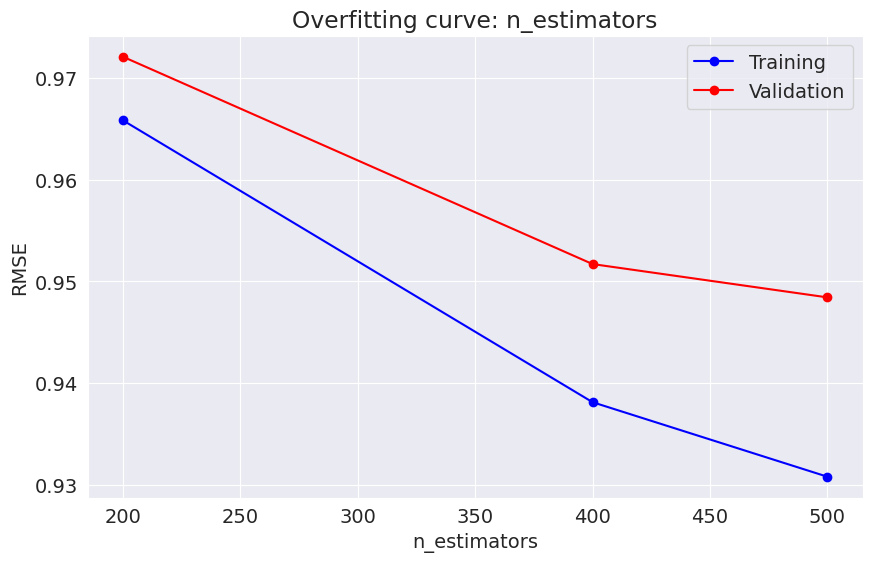

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'n_estimators', [200,400,500], **best_params)

In [ ]:
best_params['n_estimators'] = 500
#best_params['max_depth']=10

CPU times: user 31min 5s, sys: 3.3 s, total: 31min 8s
Wall time: 18min 1s


(0.75882375, 0.9730608)

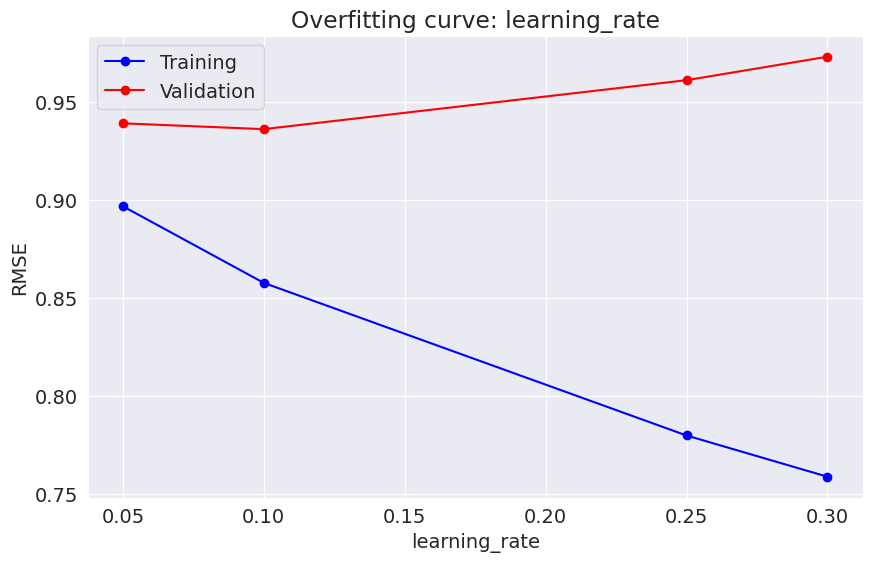

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25,0.3], **best_params)

In [ ]:
best_params['learning_rate']=0.1

**No.of leaves**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:58:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:58:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:59:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


(1.4856292, 1.4893277)

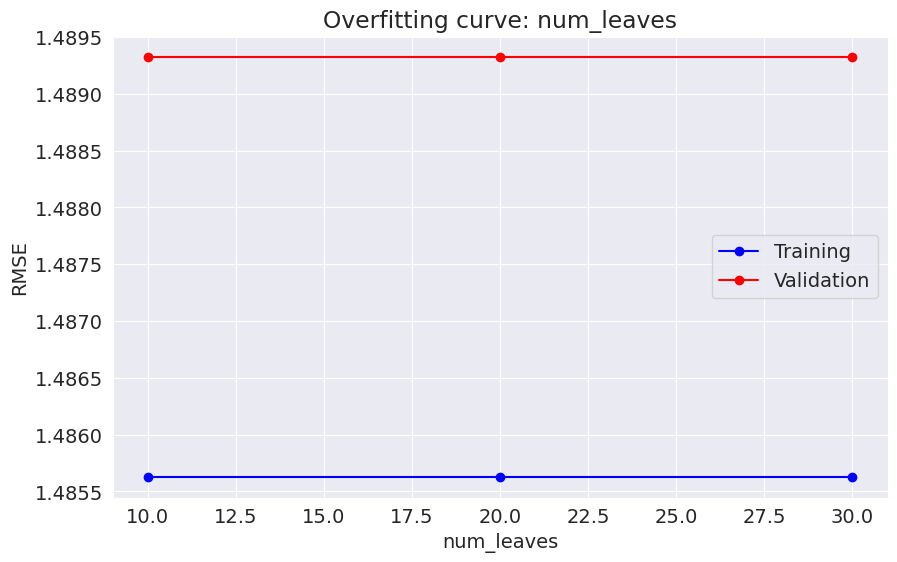

In [ ]:
test_param_and_plot(XGBRegressor, 'num_leaves', [10,20,30], **best_params)

In [ ]:
best_params['num_leaves']=10

#### LightGBM Regressor
The chosen model for our prediction task is LightGBM, developed by Microsoft, which is a gradient boosting framework utilizing a tree-based learning algorithm. Introduced in 2017, LightGBM is reputed for its efficiency, attributed to its vertical (depth-wise) tree growth approach. Unlike traditional methods, it selects a leaf for expansion based on maximum delta loss, enhancing speed. Notably, LightGBM prioritizes result accuracy and adeptly handles large datasets, outperforming other techniques. It incorporates two key techniques, Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB), contributing to its speed and efficiency.

![](https://felipesulser.github.io/images/lightgbm.png)
Since the data is widely spread with different meter types, we are training the LGBM model for each meter type separately  and merging the result. Let us use kfold for better result.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

In [ ]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model_lgbm = LGBMRegressor(random_state=33, n_jobs=-1, **params)
    model_lgbm.fit(X_train, train_targets)
    train_rmse = mean_squared_error(train_targets, model_lgbm.predict(X_train), squared=False)
    val_rmse = mean_squared_error(val_targets, model_lgbm.predict(X_val), squared=False)
    return model_lgbm, train_rmse, val_rmse

In [ ]:
kfold = KFold(n_splits=3)

In [ ]:
def train_kfold(train_df, target_meter):
  models=[]
  train_meter_df=train_df[train_df['meter']==target_meter]
  for train_idxs, val_idxs in kfold.split(train_meter_df[input_columns]):
    X_train, train_targets = train_meter_df[input_columns].iloc[train_idxs], train_meter_df[output_columns].iloc[train_idxs]
    X_val, val_targets = train_meter_df[input_columns].iloc[val_idxs], train_meter_df[output_columns].iloc[val_idxs]
    model_lgbm, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets)
    models.append(model_lgbm)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
  del train_meter_df
  return models

In [ ]:
models0=train_kfold(train_merge_df,0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.421514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 8040606, number of used features: 15
[LightGBM] [Info] Start training from score 4.020276
Train RMSE: 0.7383646142053314, Validation RMSE: 0.9915631072516708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.432307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 8040607, number of used features: 15
[LightGBM] [Info] Start training from score 3.877681
Train RMSE: 0.7097666634807539, Validation RMSE: 1.1654506059375613
[LightGBM] [Info] Auto-choosing row-wise multi-t

In [ ]:
models1=train_kfold(train_merge_df,1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 2788293, number of used features: 15
[LightGBM] [Info] Start training from score 4.540254
Train RMSE: 1.294553687374714, Validation RMSE: 1.5644325306237532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 2788293, number of used features: 15
[LightGBM] [Info] Start training from score 3.744757
Train RMSE: 1.3305338623108514, Validation RMSE: 1.5123360857785093
[LightGBM] [Info] Auto-choosing row-wise multi-th

In [ ]:
models2=train_kfold(train_merge_df,2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1805808, number of used features: 15
[LightGBM] [Info] Start training from score 4.834462
Train RMSE: 1.312715244259638, Validation RMSE: 1.6775169830710313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.404403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 1805809, number of used features: 15
[LightGBM] [Info] Start training from score 5.510361
Train RMSE: 1.2735357981271411, Validation RMSE: 1.778468459860991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096169 seconds.
You can se

In [ ]:
models3=train_kfold(train_merge_df,3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 842691, number of used features: 15
[LightGBM] [Info] Start training from score 2.947750
Train RMSE: 1.2816115489709543, Validation RMSE: 1.8244913130823066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.377005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1097
[LightGBM] [Info] Number of data points in the train set: 842691, number of used features: 15
[LightGBM] [Info] Start training from score 3.696374
Train RMSE: 1.3484536793032864, Validation RMSE: 1.5423653748368693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040964 seconds.
You can se

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
test0_preds=predict_avg(models0,test_df[test_df['meter']==0][input_columns])
test1_preds=predict_avg(models1,test_df[test_df['meter']==1][input_columns])
test2_preds=predict_avg(models2,test_df[test_df['meter']==2][input_columns])
test3_preds=predict_avg(models3,test_df[test_df['meter']==3][input_columns])

In [ ]:
test_df.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(test0_preds)
test_df.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(test1_preds)
test_df.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(test2_preds)
test_df.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(test3_preds)

In [ ]:
test_df.loc[test_df[test_df['site_id']==0].index,'meter_reading']=test_df[test_df['site_id']==0]['meter_reading']*3.4118

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/sample_submission.csv')
sample_submission['meter_reading']=round(test_df['meter_reading'],4)
sample_submission.loc[sample_submission[sample_submission['meter_reading']<0].index,'meter_reading']=0

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/ashrae-energy-prediction/meterlgbmcloud_submission.csv', index=None)

In [ ]:
sample_submission

#### Hyperparameter tuning for LGBM model
Let us tune the hyperpameters of LGBM model using the helper function defined in XGBOOST hyperparameter tuning section.

**n_estimators**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.432581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

(0.9526172062578245, 0.9603602528862465)

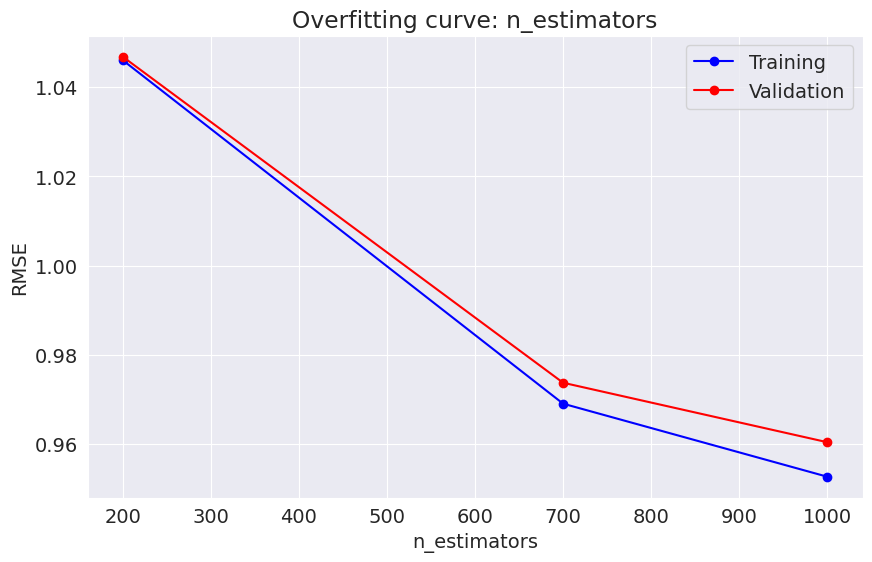

In [ ]:
test_param_and_plot(LGBMRegressor, 'n_estimators', [200,700,1000], **best_params)

In [ ]:
best_params['n_estimators']=1000

**max_depth**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

(0.9526172062578245, 0.9603602528862465)

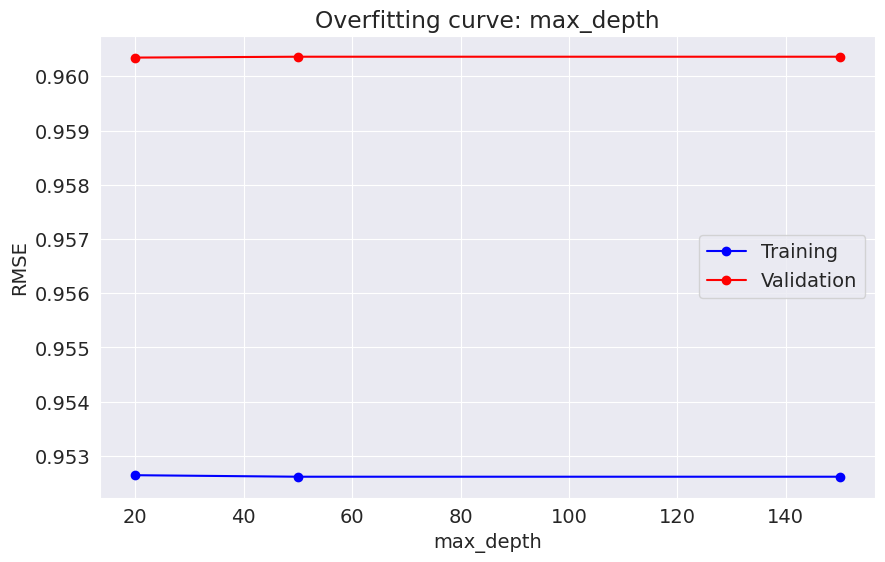

In [ ]:
test_param_and_plot(LGBMRegressor, 'max_depth', [20,50,150], **best_params)

In [ ]:
best_params['max_depth']=50

**learning_rate**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

(0.9110201522010866, 0.9413468906498406)

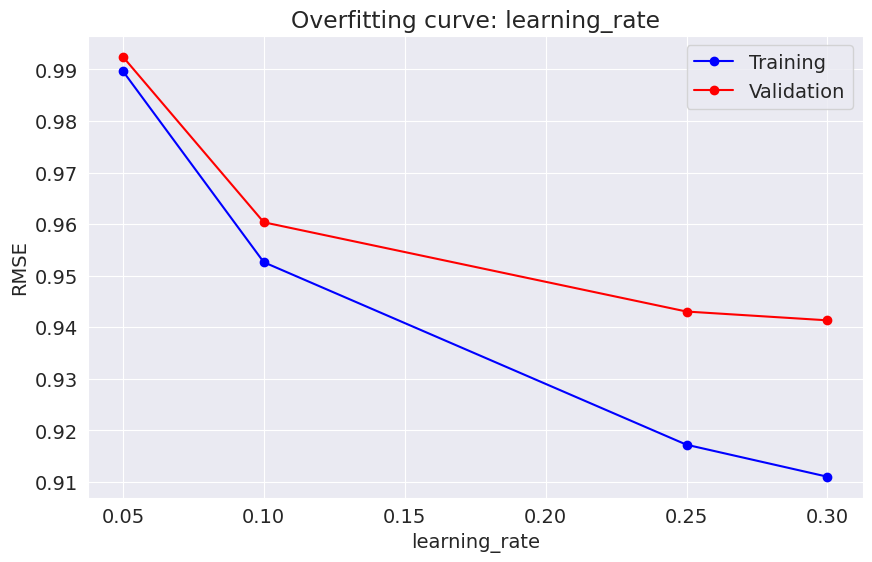

In [ ]:
%%time
test_param_and_plot(LGBMRegressor, 'learning_rate', [0.05, 0.1, 0.25,0.3], **best_params)

In [ ]:
best_params['learning_rate']=0.25

**num_leaves**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

(0.8562290148024659, 0.9438086058117248)

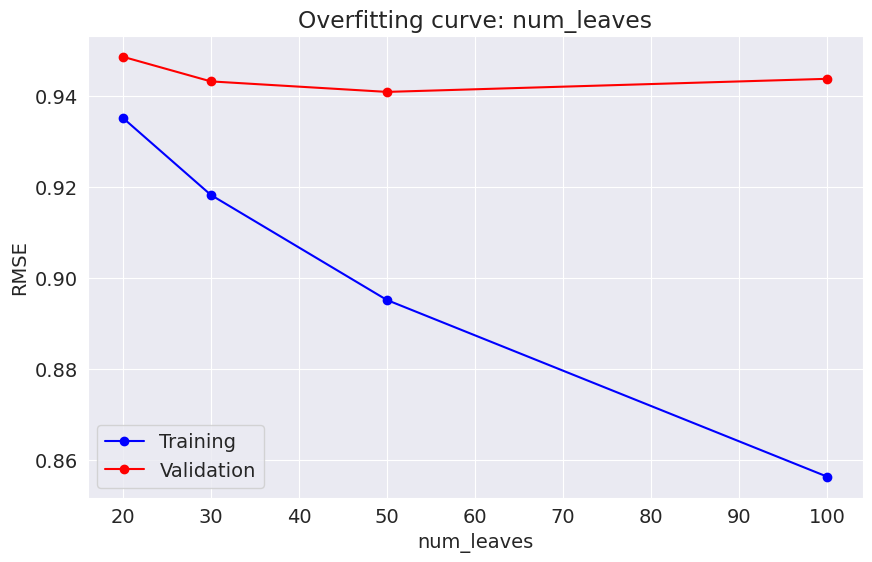

In [ ]:
test_param_and_plot(LGBMRegressor, 'num_leaves', [20,30,50,100], **best_params)

In [ ]:
best_params['num_leaves']=50

In [ ]:
best_params.pop('random_state')

33

**random_state**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1360
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 2198543, number of used features: 15
[LightGBM] [Info] Start training from score 4.519082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

(0.8947685227566269, 0.9406230945231943)

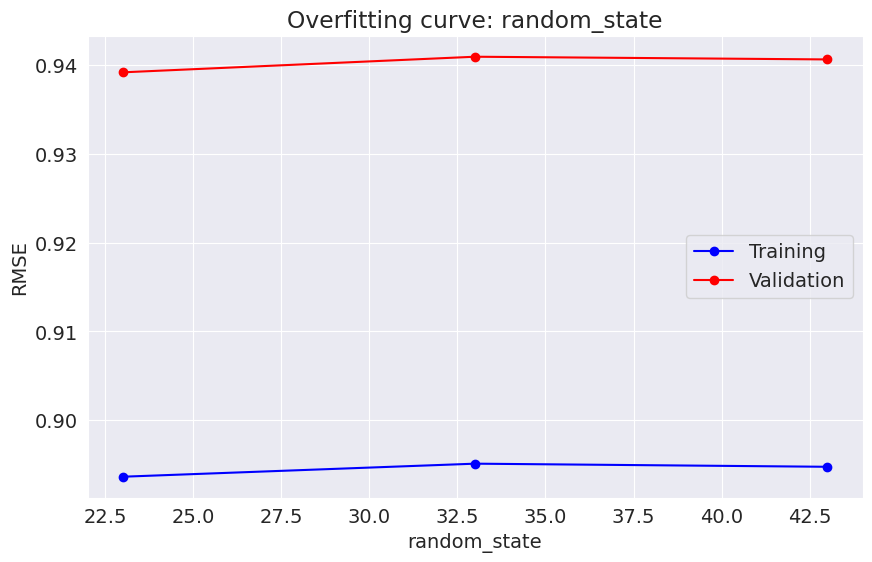

In [ ]:
test_param_and_plot( LGBMRegressor,'random_state', [23,33,43],**best_params)

In [ ]:
best_params['random_state']=33

#### LGBM Model with kfold and tuned hyperparameters
Let us use all the above tuned hyperparameters and train the model.

In [ ]:
def train_kfold(train_df, target_meter):
  models=[]
  train_meter_df=train_df[train_df['meter']==target_meter]
  for train_idxs, val_idxs in kfold.split(train_meter_df[input_columns]):
    X_train, train_targets = train_meter_df[input_columns].iloc[train_idxs], train_meter_df[output_columns].iloc[train_idxs]
    X_val, val_targets = train_meter_df[input_columns].iloc[val_idxs], train_meter_df[output_columns].iloc[val_idxs]
    model_lgbm, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,n_estimators=1000,max_depth=50,learning_rate=0.25,num_leaves=50,subsample=0.9,colsample_bytree=0.7)
    models.append(model_lgbm)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
  del train_meter_df
  return models

In [ ]:
models0=train_kfold(train_merge_df,0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 7679061, number of used features: 15
[LightGBM] [Info] Start training from score 4.105478
Train RMSE: 0.23541450490477164, Validation RMSE: 0.42784228931878054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.537255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 7679061, number of used features: 15
[LightGBM] [Info] Start training from score 4.089911
Train RMSE: 0.23306057688317733, Validation RMSE: 0.39193939297828284
[LightGBM] [Info] Auto-choosing row-wise mul

In [ ]:
models1=train_kfold(train_merge_df,1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 2350624, number of used features: 15
[LightGBM] [Info] Start training from score 5.174175
Train RMSE: 0.38503573616806225, Validation RMSE: 0.8180257362545571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.426308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 2350624, number of used features: 15
[LightGBM] [Info] Start training from score 4.697424
Train RMSE: 0.4231185175368007, Validation RMSE: 0.6413293179240988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.675965 seconds.
You can

In [ ]:
models2=train_kfold(train_merge_df,2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 1568646, number of used features: 15
[LightGBM] [Info] Start training from score 5.657644
Train RMSE: 0.4179841315989999, Validation RMSE: 0.947097227879119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 1568646, number of used features: 15
[LightGBM] [Info] Start training from score 6.128036
Train RMSE: 0.37662168975524624, Validation RMSE: 0.8290268588650753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256714 seconds.
You can 

In [ ]:
models3=train_kfold(train_merge_df,3)

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
test0_preds=predict_avg(models0,test_df[test_df['meter']==0][input_columns])
test1_preds=predict_avg(models1,test_df[test_df['meter']==1][input_columns])
test2_preds=predict_avg(models2,test_df[test_df['meter']==2][input_columns])
test3_preds=predict_avg(models3,test_df[test_df['meter']==3][input_columns])

In [ ]:
test_df.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(test0_preds)
test_df.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(test1_preds)
test_df.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(test2_preds)
test_df.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(test3_preds)

# Additional EDA Insights

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb

In [ ]:
#Loading the train data
train= pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/train.csv')
weather_train= pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/weather_train.csv')

In [ ]:
building= pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/building_metadata.csv')

In [ ]:
#Loading the test data
test= pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/test.csv')
weather_test=pd.read_csv('/content/drive/MyDrive/ashrae-energy-prediction/weather_test.csv')

In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype

        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train= reduce_mem_usage(train, use_float16=True)
weather_train= reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%


In [ ]:
test= reduce_mem_usage(test)
weather_test= reduce_mem_usage(weather_test)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.53 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.13 MB
Decreased by 73.0%


In [ ]:
#We will combine the all the data for train set in a single dataframe and test set in another dataframe
train_df= train.merge(building, on='building_id', how='left')

In [ ]:
test_df= test.merge(building, on='building_id', how='left')

In [ ]:
train_df=train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_df=test_df.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [ ]:
train_df.head()

building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  air_temperature  \
0   Education         7432      2008.0          NaN             25.0   
1   Education         2720      2004.0          NaN             25.0   
2   Education         5376      1991.0          NaN             25.0   
3   Education        23685      2002.0          NaN             25.0   
4   Education       116607      1975.0          NaN             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              1019.5   
1             6.0             20.0                NaN              1019.5   
2             6.0             20.0                NaN              1019.5   
3             6.0             20.0                NaN              1019.5   
4             6.0             20.0                NaN              1019.5   

   wind_direction  wind_speed  
0             0.0         0.0  
1             0.0         0.0  
2             0.0         0.0  
3             0.0         0.0  
4             0.0         0.0

In [ ]:
test_df.head()

row_id  building_id  meter            timestamp  site_id primary_use  \
0       0            0      0  2017-01-01 00:00:00        0   Education   
1       1            1      0  2017-01-01 00:00:00        0   Education   
2       2            2      0  2017-01-01 00:00:00        0   Education   
3       3            3      0  2017-01-01 00:00:00        0   Education   
4       4            4      0  2017-01-01 00:00:00        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN        17.796875             4.0   
1         2720      2004.0          NaN        17.796875             4.0   
2         5376      1991.0          NaN        17.796875             4.0   
3        23685      2002.0          NaN        17.796875             4.0   
4       116607      1975.0          NaN        17.796875             4.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0        11.703125                NaN              1021.5           100.0   
1        11.703125                NaN              1021.5           100.0   
2        11.703125                NaN              1021.5           100.0   
3        11.703125                NaN              1021.5           100.0   
4        11.703125                NaN              1021.5           100.0   

   wind_speed  
0    3.599609  
1    3.599609  
2    3.599609  
3    3.599609  
4    3.599609

In [ ]:
#We will break the timestamp into hour of the day, day of the week and month of the year

def break_datetime(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day)
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

  train_df= break_datetime(train_df)

In [ ]:
train_df= break_datetime(train_df)

In [ ]:
train_df.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  ...  \
0         7432      2008.0          NaN             25.0  ...   
1         2720      2004.0          NaN             25.0  ...   
2         5376      1991.0          NaN             25.0  ...   
3        23685      2002.0          NaN             25.0  ...   
4       116607      1975.0          NaN             25.0  ...   

   precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  hour  \
0                NaN              1019.5             0.0         0.0     0   
1                NaN              1019.5             0.0         0.0     0   
2                NaN              1019.5             0.0         0.0     0   
3                NaN              1019.5             0.0         0.0     0   
4                NaN              1019.5             0.0         0.0     0   

   dayofweek  month  dayofyear  day  year  
0          4      1          1    1  2016  
1          4      1          1    1  2016  
2          4      1          1    1  2016  
3          4      1          1    1  2016  
4          4      1          1    1  2016  

[5 rows x 22 columns]

In [ ]:
test_df= break_datetime(test_df)

In [ ]:
#checking the descriptive statistics for the target variable

train_df['meter_reading'].describe()

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
sns.set_style('darkgrid')

In [ ]:
train_df['meter_reading']=np.log1p(train_df['meter_reading'])

<ipython-input-26-9449ae2b6f54>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['meter_reading'])


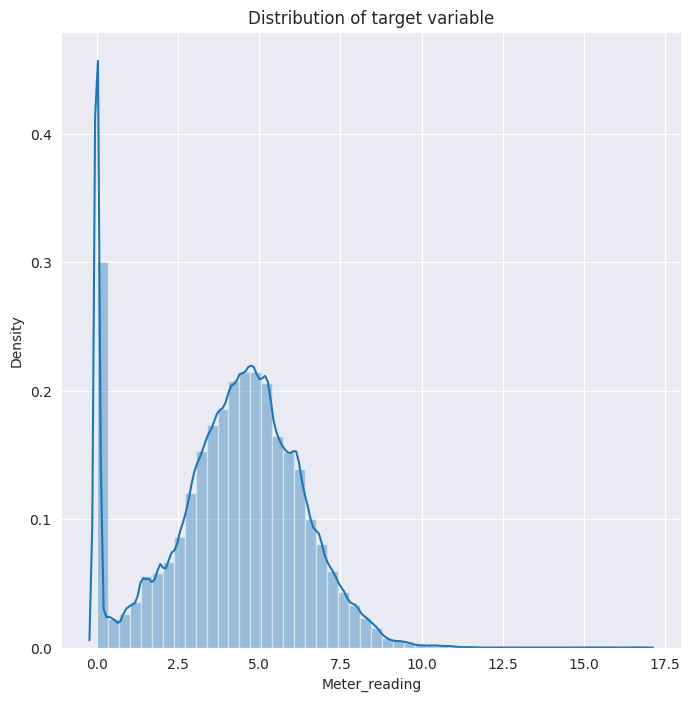

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

###Average hourly reading

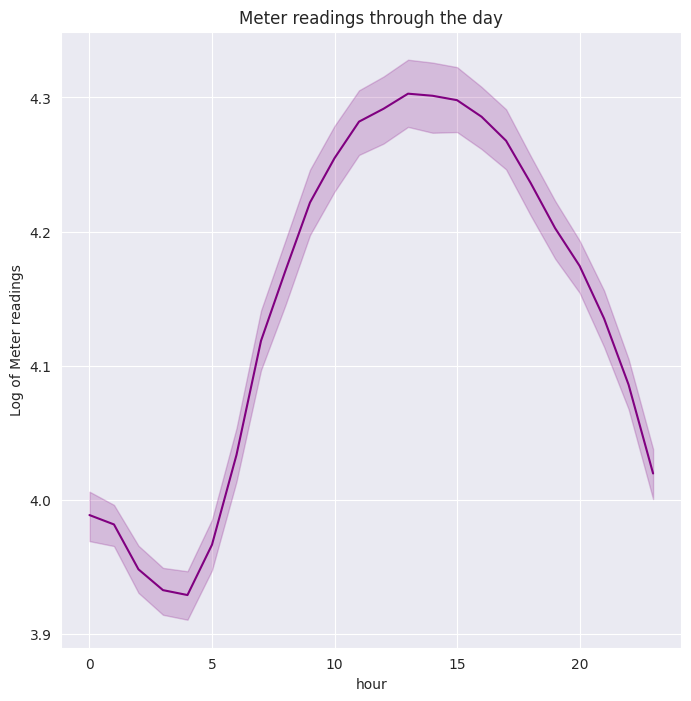

In [ ]:
#Lets check the hour wise usage of power
plt.figure(figsize=(8,8))
hour_df= train_df.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
sns.lineplot(x=hour_df['hour'], y=hour_df['meter_reading'], color='purple')
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the day")
plt.show()

###Average monthly usage

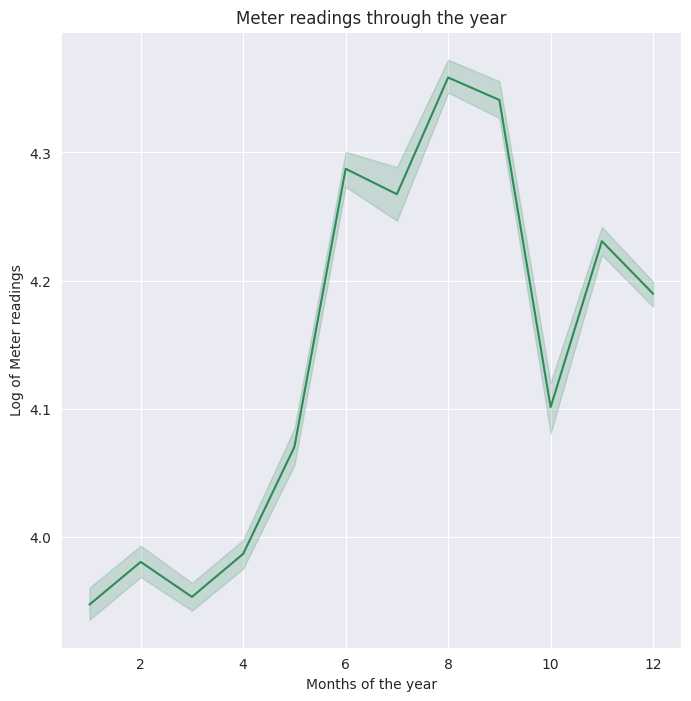

In [ ]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= train_df.groupby(['timestamp','month']).meter_reading.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['meter_reading'], color='seagreen')
plt.xlabel("Months of the year")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the year")
plt.show()

In [ ]:
#lets specify the category names of meter id codes
train_df['meter'].replace({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}, inplace=True)

###Count plots of primary use

<Axes: xlabel='count', ylabel='primary_use'>

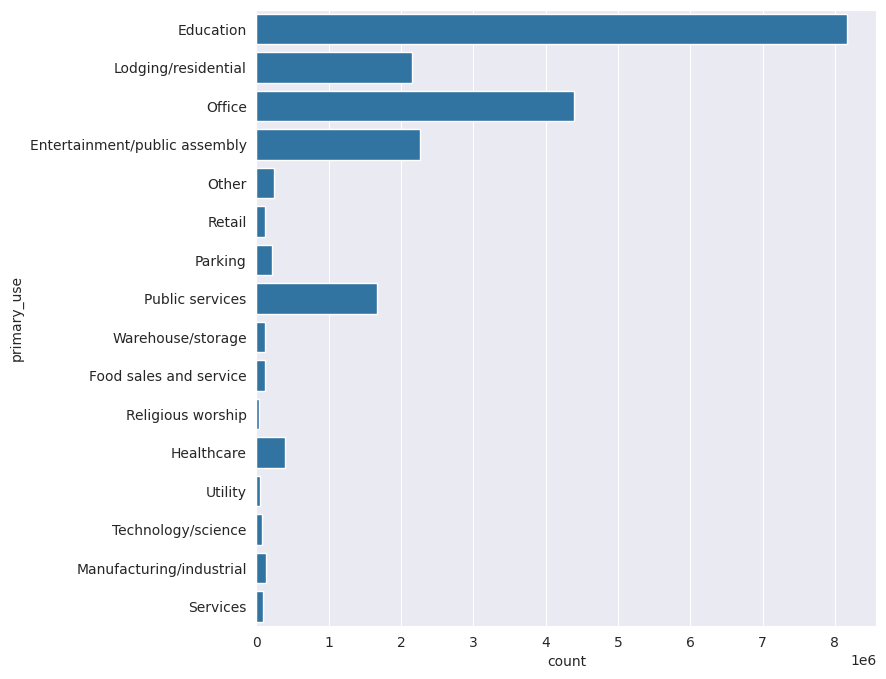

In [ ]:
#Primary usage plots
#Count plot for each primary usage category
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_df)

###Count plot for Meter types

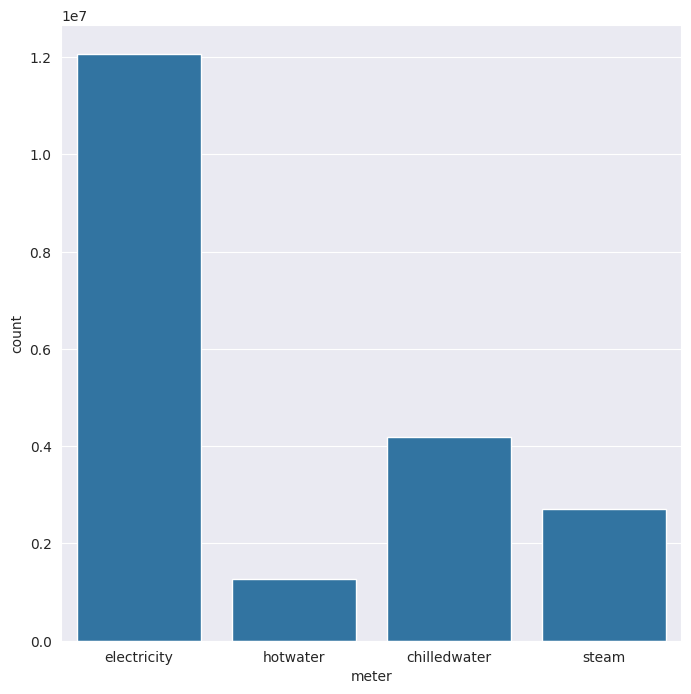

In [ ]:
#Count plot for each meter category
plt.figure(figsize=(8,8))
p=sns.countplot(x='meter', data=train_df)

###Average meter reading by meter types

<ipython-input-33-1b5af6ec598b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.barplot(x='meter', y='meter_reading', data=meter_df, palette='pastel')


Text(0.5, 1.0, 'Average meter readings by meter types')

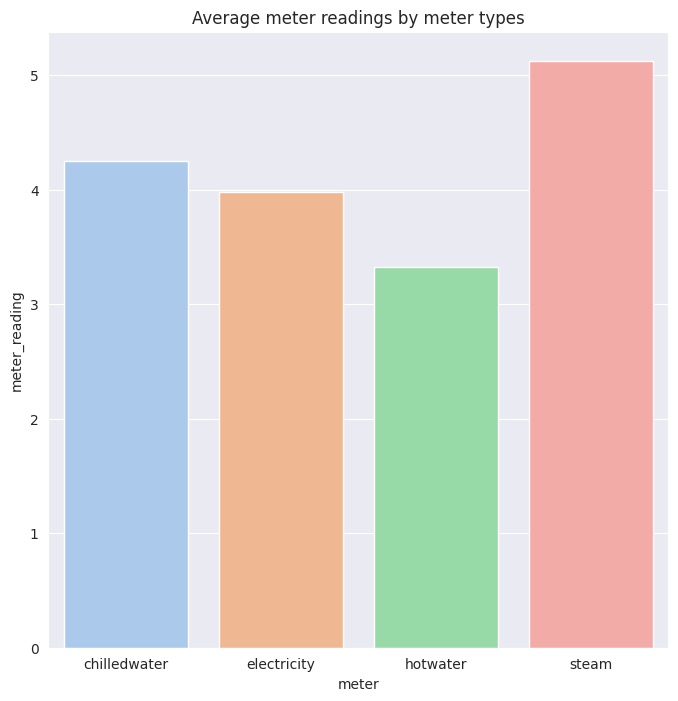

In [ ]:
#Meter readings for each meter category
plt.figure(figsize=(8,8))
meter_df= train_df.groupby('meter').meter_reading.mean().reset_index()
ax= sns.barplot(x='meter', y='meter_reading', data=meter_df, palette='pastel')
plt.title("Average meter readings by meter types")

###Average hourly consumption by primary use

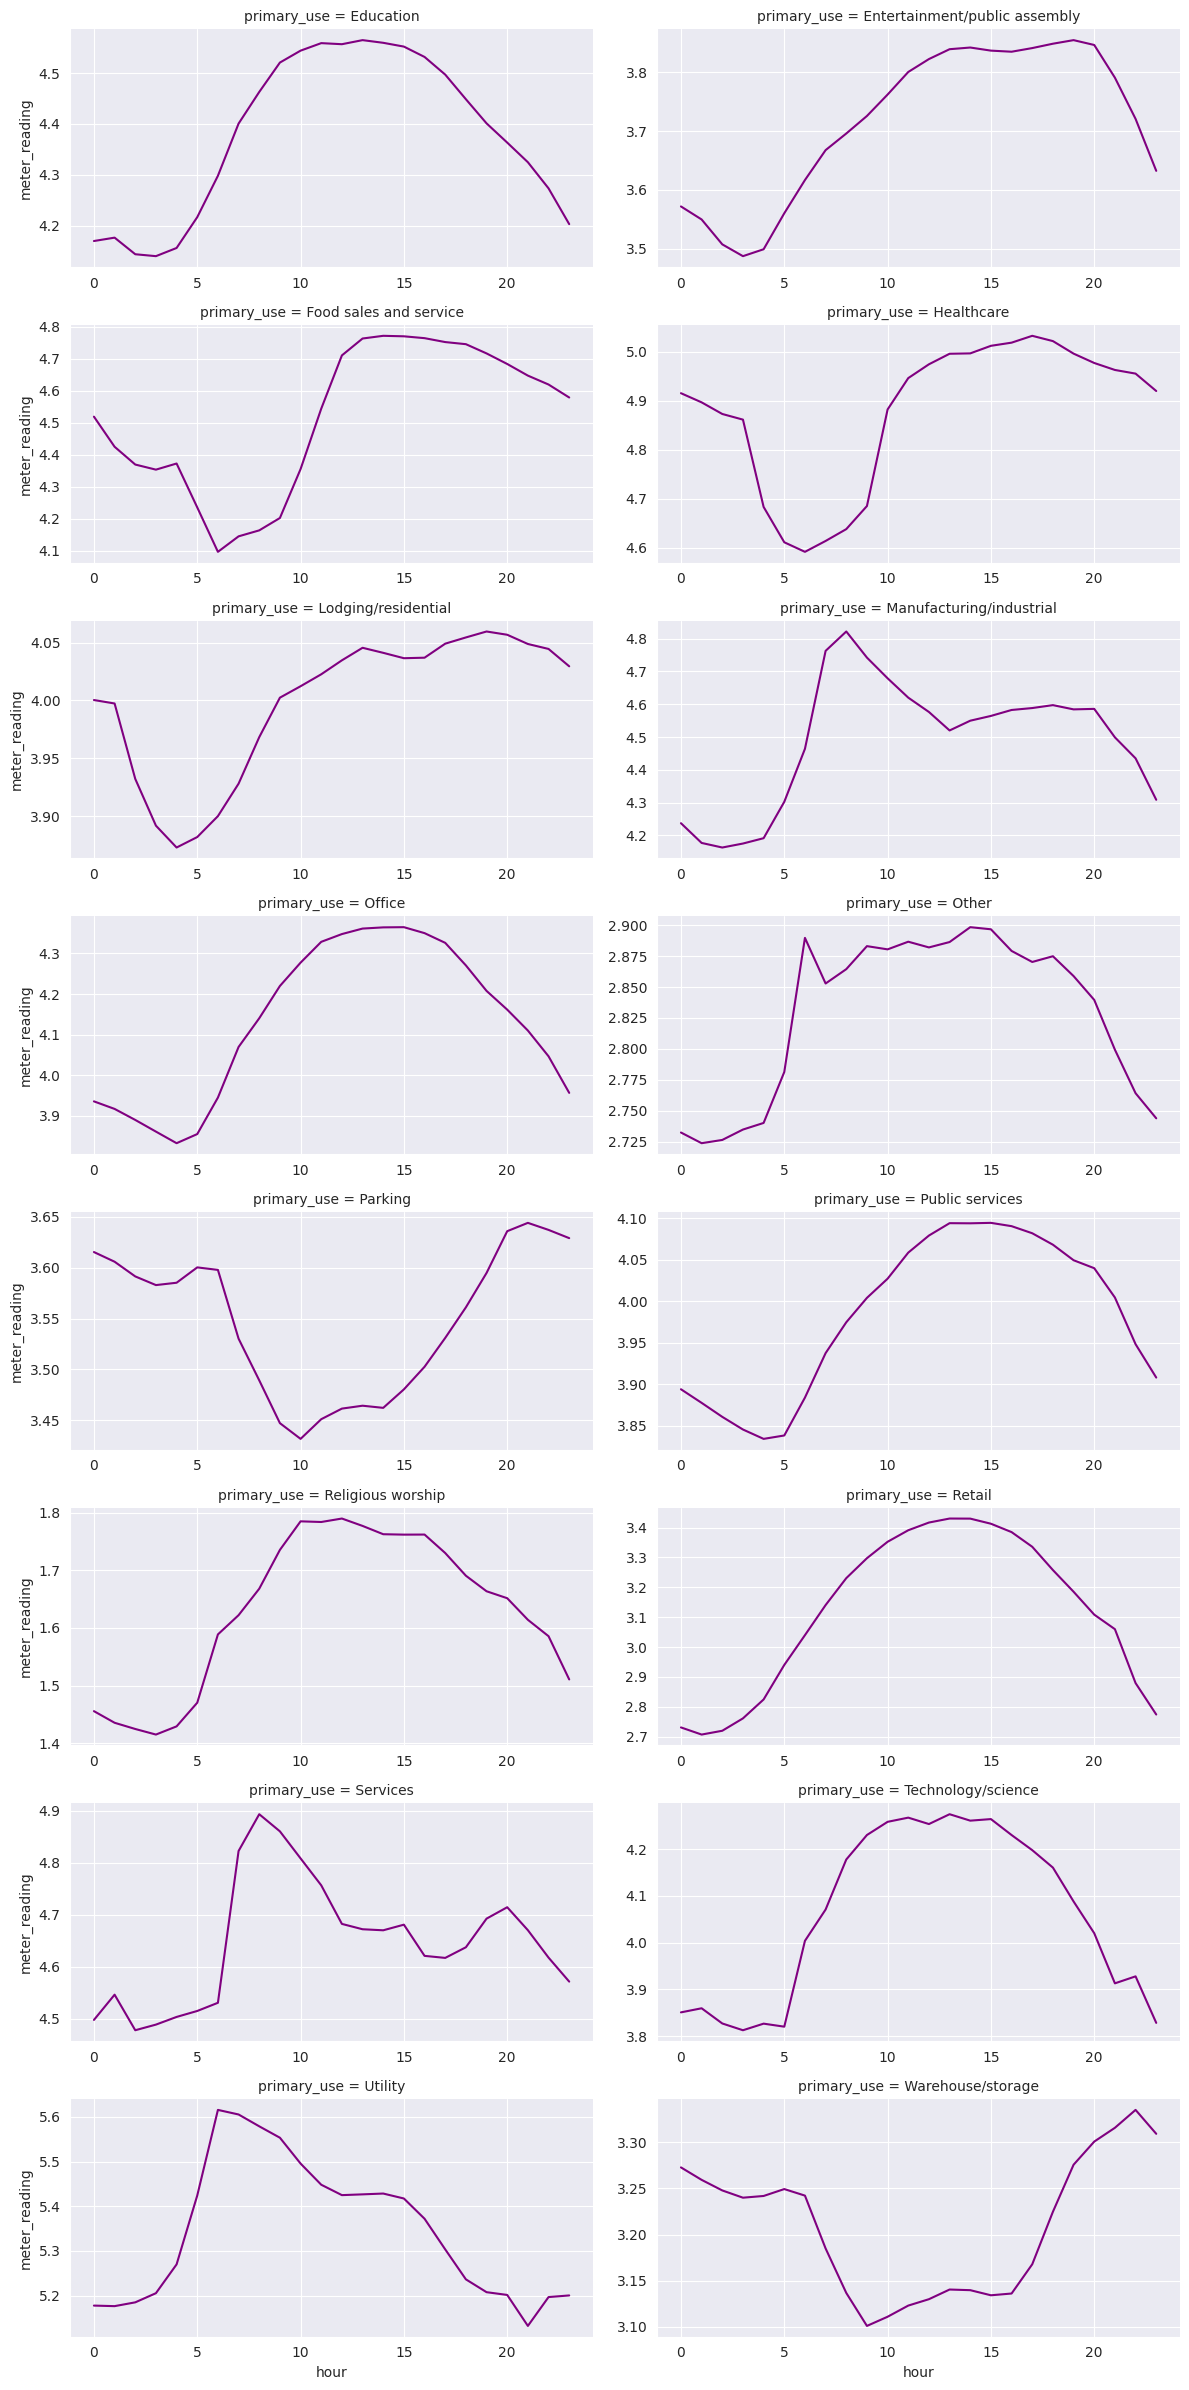

In [ ]:
#Hourly average readings based on type of buildings
hour_use_df= train_df.groupby(['hour', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='primary_use', col_wrap=2, height=3, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'hour', 'meter_reading', color='purple')
plt.show()

### Average monthly consumption by primary use

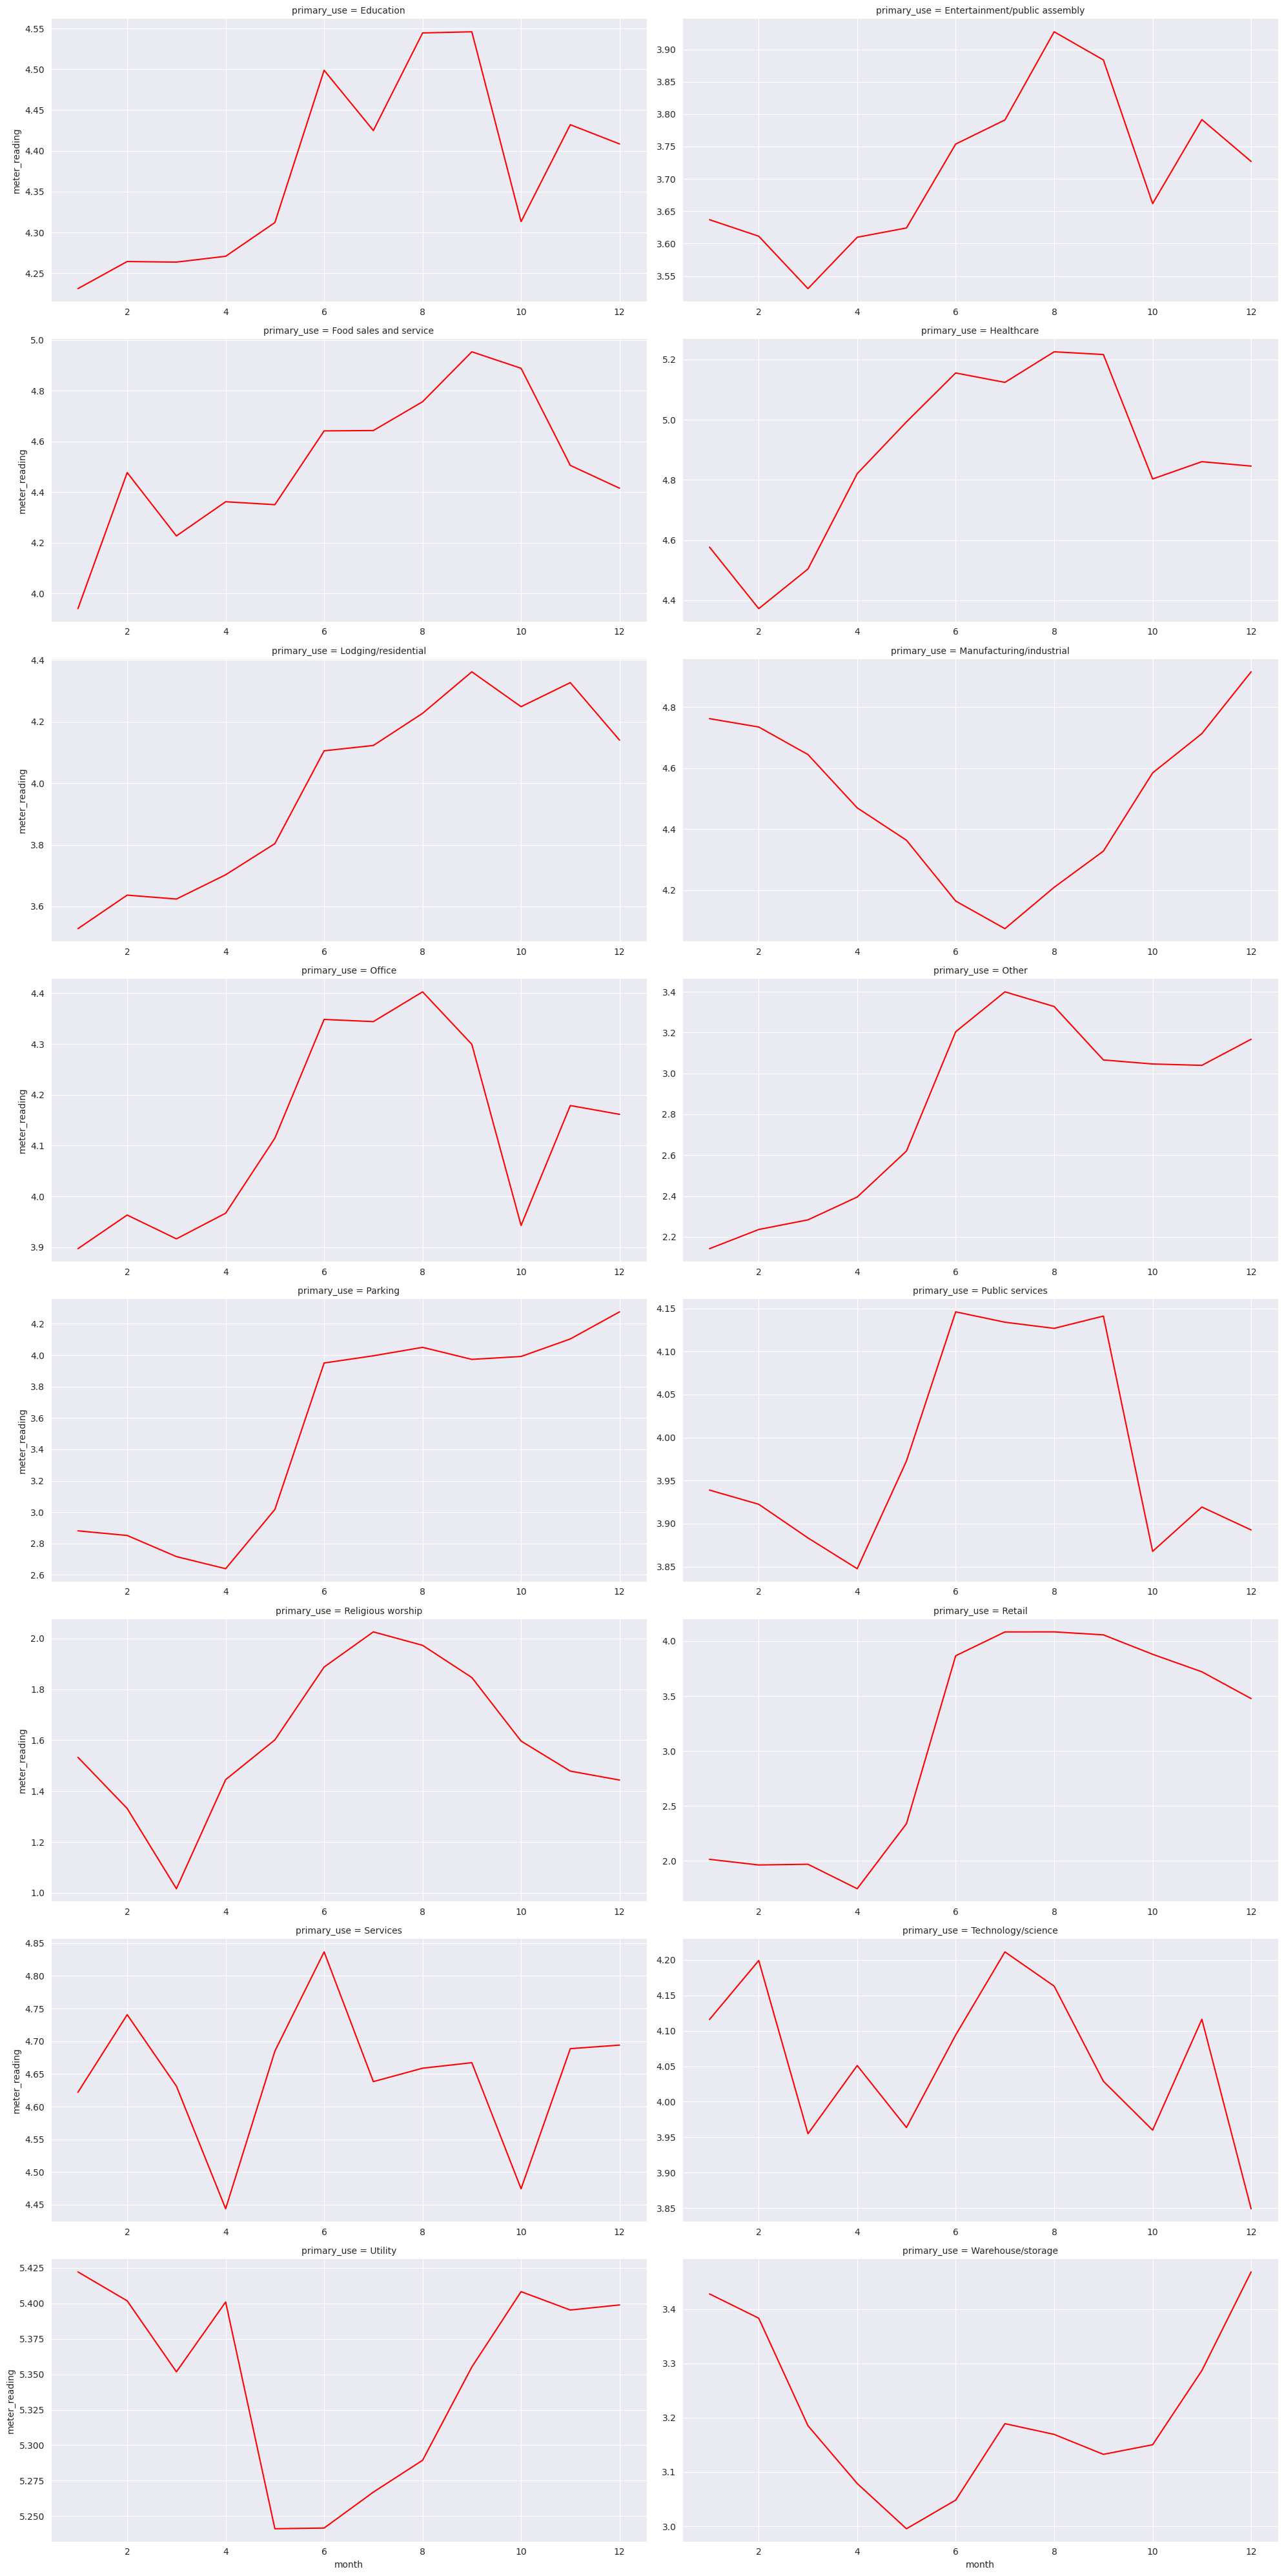

In [ ]:
#Monthy average readings based on type of buildings
month_use_df= train_df.groupby(['month', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(month_use_df, col='primary_use', col_wrap=2, height=5, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'month', 'meter_reading', color='red')
plt.show()


The figure illustrates the average hourly usage for each primary usage category:

* Educational institutes exhibit peak usage during August and September, with minimum usage observed in the early months of the year.
* Entertainment and food sales buildings experience a rise in consumption from March to August, with a decline thereafter.
* Manufacturing shows a distinct decreasing trend, reaching its lowest point in July before gradually increasing again.

### Mean meter readings by square feet

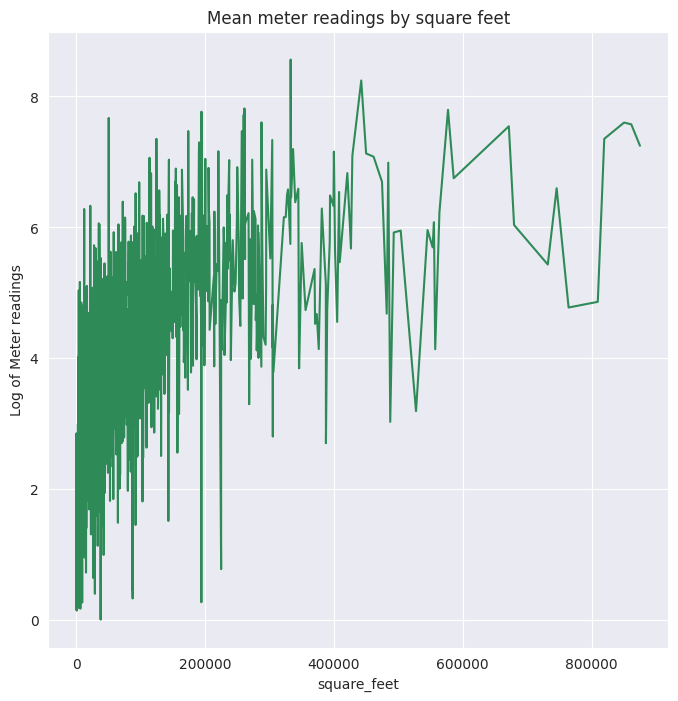

In [ ]:
plt.figure(figsize=(8,8))
feet_df= train_df.groupby('square_feet').meter_reading.mean().reset_index()
sns.lineplot(x=feet_df['square_feet'], y=feet_df['meter_reading'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by square feet")
plt.show()

There is clear positive relation between the two. As the size of the building increases, the meter consumption also increases.

### Correlation Matrix

<ipython-input-36-c81c04a004f4>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')


Text(0.5, 1.0, 'Correlation Matrix')

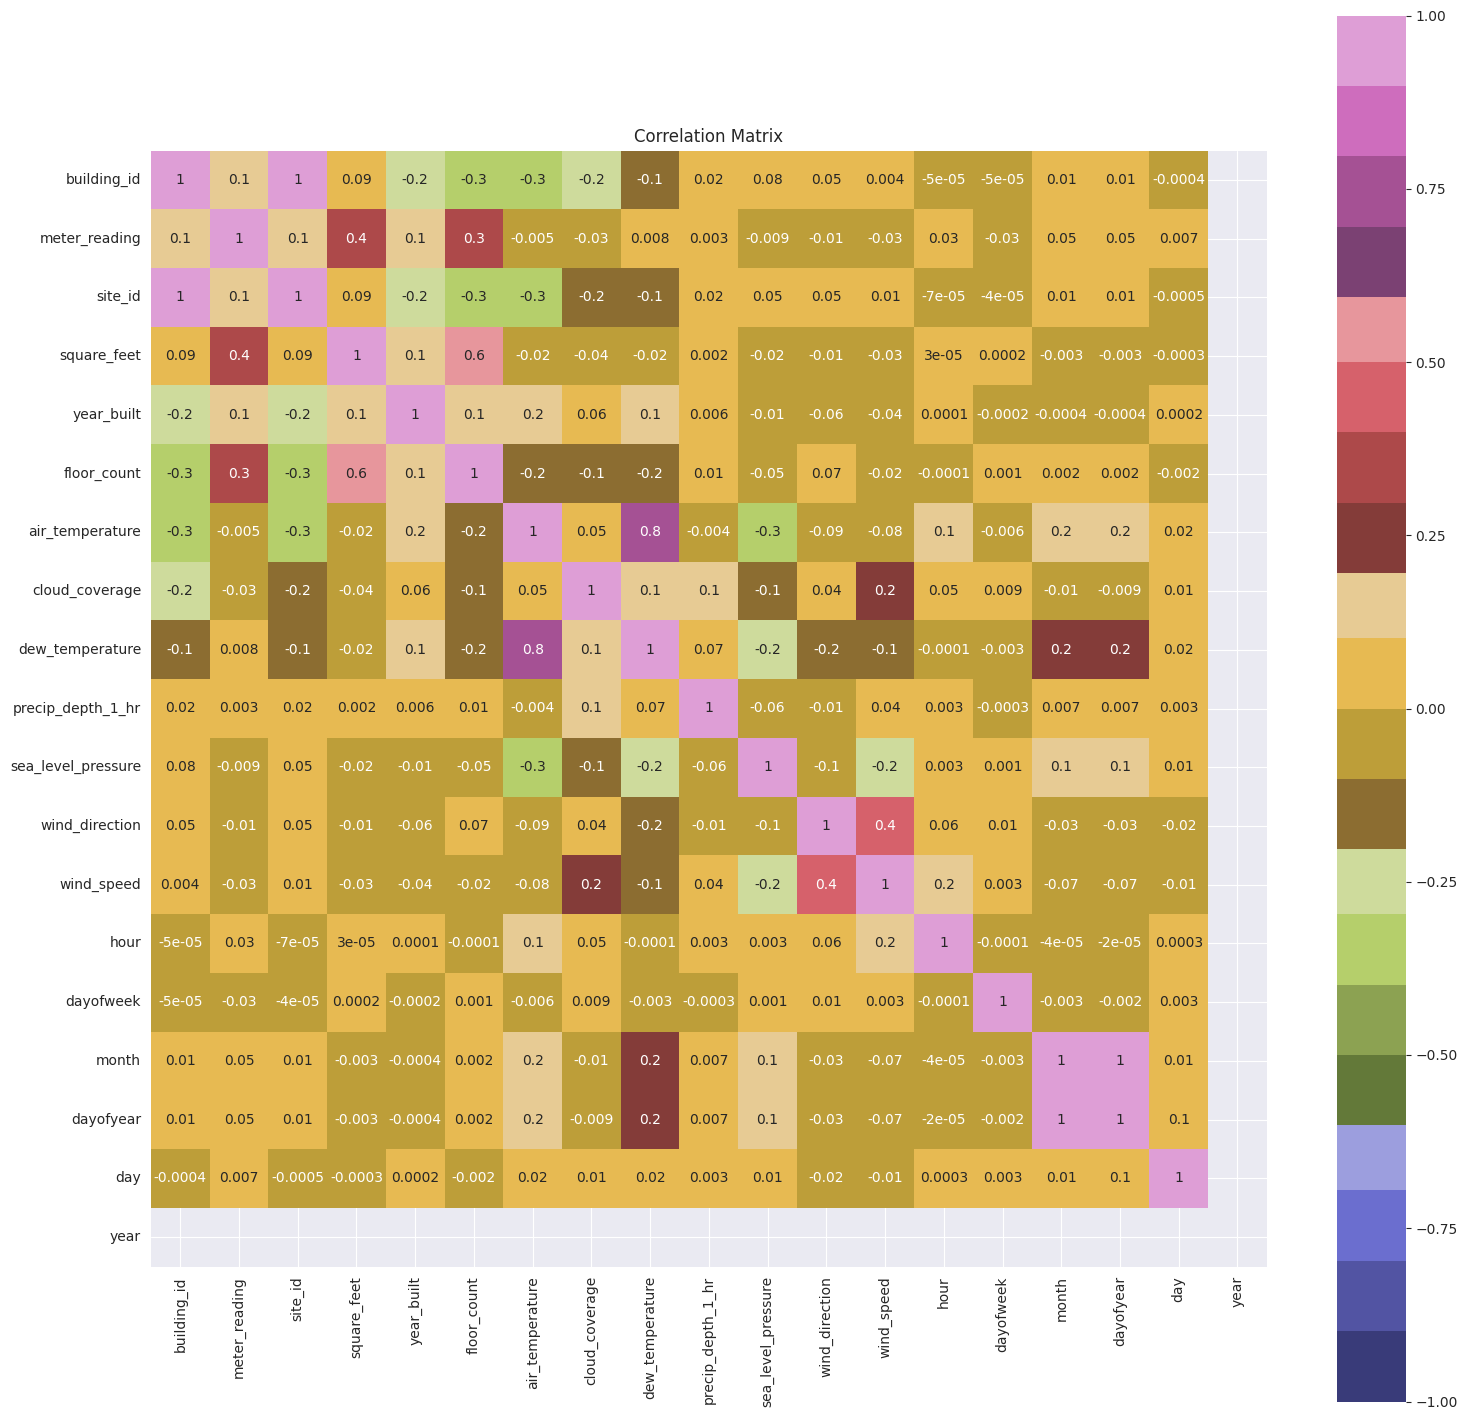

In [ ]:
#Correlation Matrix
plt.figure(figsize=(18,18))
sns.heatmap(train_df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')
plt.title('Correlation Matrix')